<img width="30%" src="https://ts.gluon.ai/dev/_static/gluonts.svg" alt="GluonTS logo" style="display: block; margin-left: auto; margin-right: auto;">

# Lab 1A: GluonTS

[GluonTS](https://ts.gluon.ai/stable/) is a Python library for probabilistic time series modeling, with a focus on deep learning-based approaches. 

First introduced in the [paper](https://www.jmlr.org/papers/volume21/19-820/19-820.pdf), it provides a toolkit for tasks such as forecasting and anomaly detection, simplifying the development and experimentation process for time series models. Supporting both PyTorch and MXNet implementations, GluonTS offers a modular and scalable design that is suitable for both experimentation and production use.

Refer to the blog post [Creating neural time series models with Gluon Time Series](https://aws.amazon.com/blogs/machine-learning/creating-neural-time-series-models-with-gluon-time-series/) for an introduction to GluonTS.

The library includes essential components like neural network architectures for sequences, feature processing steps, and [evaluation](https://ts.gluon.ai/stable/api/gluonts/gluonts.evaluation.html). It also comes with pre-built implementations of state-of-the-art [models](https://ts.gluon.ai/stable/getting_started/models.html), allowing for easy benchmarking and comparison. GluonTS supports various [data formats](https://ts.gluon.ai/stable/api/gluonts/gluonts.dataset.html) and provides [data loading](https://ts.gluon.ai/stable/api/gluonts/gluonts.dataset.loader.html) and iteration capabilities, making it suitable for handling large-scale time series datasets. Whether you're a scientist developing new models or a practitioner looking for out-of-the-box solutions, GluonTS offers the flexibility and tools needed to tackle complex time series problems.

## Import packages

In [ ]:
# downgrade sentencepiece to 0.1.99 because it causes incompatibility issues in SMD 2.0
# this is fixed in SMD >= 2.1.0
# %pip -q install sentencepiece==0.1.99

In [ ]:
%pip -q install --upgrade seaborn orjson statsmodels "gluonts[mxnet]" gluonts[Prophet]

In [1]:
# Uncomment if you need to restart kernel to get the packages
# import IPython
# IPython.Application.instance().kernel.do_shutdown(True)

In [1]:
# you need gluonts >= 0.15.1 otherwise DeepAR is not going to work
%pip show gluonts

Name: gluonts
Version: 0.15.1
Summary: Probabilistic time series modeling in Python.
Home-page: https://github.com/awslabs/gluonts/
Author: Amazon
Author-email: gluon-ts-dev@amazon.com
License: Apache License 2.0
Location: /opt/conda/lib/python3.11/site-packages
Requires: numpy, pandas, pydantic, toolz, tqdm, typing-extensions
Required-by: autogluon.timeseries
Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline

import json
import os
import zipfile
from time import gmtime, strftime, sleep
import random
import seaborn as sns
import matplotlib.pyplot as plt
import boto3
import sagemaker
import tqdm
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
from scipy.stats import normaltest
import warnings
warnings.filterwarnings('ignore')
import matplotlib.colors as mcolors
import itertools
import ipywidgets as widgets
from ipywidgets import (
interact, interactive, fixed, interact_manual,
IntSlider, Checkbox, Dropdown, DatePicker, Select, SelectMultiple, Checkbox
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [3]:
# setup plt environment
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (20, 3)
colors = list(mcolors.TABLEAU_COLORS)

## Set literals and general variables

In [4]:
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name

In [5]:
s3_bucket = sagemaker_session.default_bucket()  # replace with an existing bucket if needed
s3_prefix = "gluonts-demo-notebook"  # prefix used for all data stored within the bucket
experiment_prefix = "gluonts"
extract_to_path = '../data'

sm_role = sagemaker.get_execution_role()  # IAM role to use by SageMaker

## Download the dataset

Download the from the SageMaker example S3 bucket. You use the [electricity dataset](https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014) from the repository of the University of California, Irvine:
> Trindade, Artur. (2015). ElectricityLoadDiagrams20112014. UCI Machine Learning Repository. https://doi.org/10.24432/C58C86.

In [6]:
os.makedirs(extract_to_path, exist_ok=True)

In [7]:
dataset_zip_file_name = 'LD2011_2014.txt.zip'
dataset_path = f'{extract_to_path}/LD2011_2014.txt'

s3_dataset_path = f"datasets/timeseries/uci_electricity/{dataset_zip_file_name}"

In [8]:
if not os.path.isfile(dataset_path):
    print(f'Downloading and unzipping the dataset to {dataset_path}')
    s3_client = boto3.client("s3")
    s3_client.download_file(
        f"sagemaker-example-files-prod-{region}", s3_dataset_path, f"{extract_to_path}/{dataset_zip_file_name}"
    )

    with zipfile.ZipFile(f"{extract_to_path}/{dataset_zip_file_name}", "r") as zip_ref:
        total_size = sum(file.file_size for file in zip_ref.infolist())

        with tqdm.tqdm(total=total_size, unit='B', unit_scale=True, desc="Extracting") as pbar:
            for file in zip_ref.infolist():
                zip_ref.extract(file, extract_to_path)
                pbar.update(file.file_size)
        
    dataset_path = '.'.join(zip_ref.filename.split('.')[:-1])
else:
    print(f'The dataset {dataset_path} exists, skipping download and unzip!')

The dataset ../data/LD2011_2014.txt exists, skipping download and unzip!


In [9]:
# see what is inside the file
# !head -n 2 {dataset_path} 

## Explore and preprocess data

### Load into a DataFrame and resample

In [10]:
df_raw = pd.read_csv(
    dataset_path, 
    sep=';', 
    index_col=0,
    decimal=',',
    parse_dates=True,
)

In [11]:
df_raw

MT_001     MT_002    MT_003      MT_004     MT_005  \
2011-01-01 00:15:00  0.000000   0.000000  0.000000    0.000000   0.000000   
2011-01-01 00:30:00  0.000000   0.000000  0.000000    0.000000   0.000000   
2011-01-01 00:45:00  0.000000   0.000000  0.000000    0.000000   0.000000   
2011-01-01 01:00:00  0.000000   0.000000  0.000000    0.000000   0.000000   
2011-01-01 01:15:00  0.000000   0.000000  0.000000    0.000000   0.000000   
...                       ...        ...       ...         ...        ...   
2014-12-31 23:00:00  2.538071  22.048364  1.737619  150.406504  85.365854   
2014-12-31 23:15:00  2.538071  21.337127  1.737619  166.666667  81.707317   
2014-12-31 23:30:00  2.538071  20.625889  1.737619  162.601626  82.926829   
2014-12-31 23:45:00  1.269036  21.337127  1.737619  166.666667  85.365854   
2015-01-01 00:00:00  2.538071  19.914651  1.737619  178.861789  84.146341   

                         MT_006     MT_007      MT_008     MT_009     MT_010  \
2011-01-01 00:15:00    0.000000   0.000000    0.000000   0.000000   0.000000   
2011-01-01 00:30:00    0.000000   0.000000    0.000000   0.000000   0.000000   
2011-01-01 00:45:00    0.000000   0.000000    0.000000   0.000000   0.000000   
2011-01-01 01:00:00    0.000000   0.000000    0.000000   0.000000   0.000000   
2011-01-01 01:15:00    0.000000   0.000000    0.000000   0.000000   0.000000   
...                         ...        ...         ...        ...        ...   
2014-12-31 23:00:00  303.571429  11.305822  282.828283  68.181818  72.043011   
2014-12-31 23:15:00  324.404762  11.305822  252.525253  64.685315  72.043011   
2014-12-31 23:30:00  318.452381  10.175240  242.424242  61.188811  74.193548   
2014-12-31 23:45:00  285.714286  10.175240  225.589226  64.685315  72.043011   
2015-01-01 00:00:00  279.761905  10.175240  249.158249  62.937063  69.892473   

                     ...      MT_361   MT_362       MT_363       MT_364  \
2011-01-01 00:15:00  ...    0.000000      0.0     0.000000     0.000000   
2011-01-01 00:30:00  ...    0.000000      0.0     0.000000     0.000000   
2011-01-01 00:45:00  ...    0.000000      0.0     0.000000     0.000000   
2011-01-01 01:00:00  ...    0.000000      0.0     0.000000     0.000000   
2011-01-01 01:15:00  ...    0.000000      0.0     0.000000     0.000000   
...                  ...         ...      ...          ...          ...   
2014-12-31 23:00:00  ...  276.945039  28200.0  1616.033755  1363.636364   
2014-12-31 23:15:00  ...  279.800143  28300.0  1569.620253  1340.909091   
2014-12-31 23:30:00  ...  284.796574  27800.0  1556.962025  1318.181818   
2014-12-31 23:45:00  ...  246.252677  28000.0  1443.037975   909.090909   
2015-01-01 00:00:00  ...  188.436831  27800.0  1409.282700   954.545455   

                        MT_365    MT_366      MT_367      MT_368      MT_369  \
2011-01-01 00:15:00   0.000000  0.000000    0.000000    0.000000    0.000000   
2011-01-01 00:30:00   0.000000  0.000000    0.000000    0.000000    0.000000   
2011-01-01 00:45:00   0.000000  0.000000    0.000000    0.000000    0.000000   
2011-01-01 01:00:00   0.000000  0.000000    0.000000    0.000000    0.000000   
2011-01-01 01:15:00   0.000000  0.000000    0.000000    0.000000    0.000000   
...                        ...       ...         ...         ...         ...   
2014-12-31 23:00:00  29.986962  5.851375  697.102722  176.961603  651.026393   
2014-12-31 23:15:00  29.986962  9.947338  671.641791  168.614357  669.354839   
2014-12-31 23:30:00  27.379400  9.362200  670.763828  153.589316  670.087977   
2014-12-31 23:45:00  26.075619  4.095963  664.618086  146.911519  646.627566   
2015-01-01 00:00:00  27.379400  4.095963  628.621598  131.886477  673.020528   

                          MT_370  
2011-01-01 00:15:00     0.000000  
2011-01-01 00:30:00     0.000000  
2011-01-01 00:45:00     0.000000  
2011-01-01 01:00:00     0.000000  
2011-01-01 01:15:00     0.000000  
...                          ...  
2014-12-31 23:00:00  7621.6216

In [12]:
# resample to 1h intervals
freq = "1h"
div = 4 # 1 hour contain 4x 15 min intervals, you need to  delete the resampled value by 4
num_timeseries = df_raw.shape[1]
data_kw = df_raw.resample(freq).sum() / div
timeseries = []

for i in tqdm.trange(num_timeseries):
    timeseries.append(np.trim_zeros(data_kw.iloc[:, i], trim="f"))

100%|██████████| 370/370 [00:00<00:00, 1006.05it/s]


In [13]:
data_kw

MT_001     MT_002    MT_003      MT_004     MT_005  \
2011-01-01 00:00:00  0.000000   0.000000  0.000000    0.000000   0.000000   
2011-01-01 01:00:00  0.000000   0.000000  0.000000    0.000000   0.000000   
2011-01-01 02:00:00  0.000000   0.000000  0.000000    0.000000   0.000000   
2011-01-01 03:00:00  0.000000   0.000000  0.000000    0.000000   0.000000   
2011-01-01 04:00:00  0.000000   0.000000  0.000000    0.000000   0.000000   
...                       ...        ...       ...         ...        ...   
2014-12-31 20:00:00  2.220812  25.248933  1.737619  186.483740  92.073171   
2014-12-31 21:00:00  2.538071  22.759602  1.737619  162.093496  86.280488   
2014-12-31 22:00:00  1.903553  22.048364  1.737619  161.077236  86.890244   
2014-12-31 23:00:00  2.220812  21.337127  1.737619  161.585366  83.841463   
2015-01-01 00:00:00  0.634518   4.978663  0.434405   44.715447  21.036585   

                         MT_006     MT_007      MT_008     MT_009     MT_010  \
2011-01-01 00:00:00    0.000000   0.000000    0.000000   0.000000   0.000000   
2011-01-01 01:00:00    0.000000   0.000000    0.000000   0.000000   0.000000   
2011-01-01 02:00:00    0.000000   0.000000    0.000000   0.000000   0.000000   
2011-01-01 03:00:00    0.000000   0.000000    0.000000   0.000000   0.000000   
2011-01-01 04:00:00    0.000000   0.000000    0.000000   0.000000   0.000000   
...                         ...        ...         ...        ...        ...   
2014-12-31 20:00:00  340.773810  11.305822  315.656566  91.783217  81.451613   
2014-12-31 21:00:00  319.940476  11.588468  269.360269  76.486014  70.161290   
2014-12-31 22:00:00  314.732143  11.305822  251.683502  71.678322  72.311828   
2014-12-31 23:00:00  308.035714  10.740531  250.841751  64.685315  72.580645   
2015-01-01 00:00:00   69.940476   2.543810   62.289562  15.734266  17.473118   

                     ...      MT_361   MT_362       MT_363       MT_364  \
2011-01-01 00:00:00  ...    0.000000      0.0     0.000000     0.000000   
2011-01-01 01:00:00  ...    0.000000      0.0     0.000000     0.000000   
2011-01-01 02:00:00  ...    0.000000      0.0     0.000000     0.000000   
2011-01-01 03:00:00  ...    0.000000      0.0     0.000000     0.000000   
2011-01-01 04:00:00  ...    0.000000      0.0     0.000000     0.000000   
...                  ...         ...      ...          ...          ...   
2014-12-31 20:00:00  ...  333.511777  39700.0  1702.531646  2238.636364   
2014-12-31 21:00:00  ...  327.266238  38575.0  1649.789030  1477.272727   
2014-12-31 22:00:00  ...  306.209850  35475.0  1636.075949  1375.000000   
2014-12-31 23:00:00  ...  271.948608  28075.0  1546.413502  1232.954545   
2015-01-01 00:00:00  ...   47.109208   6950.0   352.320675   238.636364   

                        MT_365    MT_366      MT_367      MT_368      MT_369  \
2011-01-01 00:00:00   0.000000  0.000000    0.000000    0.000000    0.000000   
2011-01-01 01:00:00   0.000000  0.000000    0.000000    0.000000    0.000000   
2011-01-01 02:00:00   0.000000  0.000000    0.000000    0.000000    0.000000   
2011-01-01 03:00:00   0.000000  0.000000    0.000000    0.000000    0.000000   
2011-01-01 04:00:00   0.000000  0.000000    0.000000    0.000000    0.000000   
...                        ...       ...         ...         ...         ...   
2014-12-31 20:00:00  74.967405  4.388531  375.768218  108.931553  688.416422   
2014-12-31 21:00:00  74.967405  3.949678  465.539947  154.841402  662.023460   
2014-12-31 22:00:00  64.211213  7.753072  655.179982  195.325543  679.252199   
2014-12-31 23:00:00  28.357236  7.314219  676.031607  161.519199  659.274194   
2015-01-01 00:00:00   6.844850  1.023991  157.155399   32.971619  168.255132   

                          MT_370  
2011-01-01 00:00:00     0.000000  
2011-01-01 01:00:00     0.000000  
2011-01-01 02:00:00     0.000000  
2011-01-01 03:00:00     0.000000  
2011-01-01 04:00:00     0.000000  
...                          ...  
2014-12-31 20:00:00  8405.4054

### Visualize time series

In [14]:
def plot_timeseries(timeseries, start_time, length):
    n_cols = 2
    n_rows = (len(timeseries) + 1)//2
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows), sharex=True)
    axx = axs.ravel()
    for i, ts in tqdm.tqdm(enumerate(timeseries), total=len(timeseries), desc="Creating plots"):
        series = ts.loc[start_time:start_time + length*ts.index.freq]
        if len(series): series.plot(ax=axx[i])

        axx[i].set_xlabel("date")
        axx[i].set_ylabel(f"kW consumption - {ts.name} - {ts.index.freq}")
        axx[i].grid(which="minor", axis="x")
    
    plt.tight_layout()
    plt.show()

In [15]:
style = {"description_width": "initial"}
ts_id_list = [ts.name for ts in timeseries]
show_start_date = pd.Timestamp("2014-12-01")
time_step = timeseries[0].index.freq
max_samples = 64

In [16]:
timeseries[108]

2014-02-18 00:00:00    42.553191
2014-02-18 01:00:00    63.829787
2014-02-18 02:00:00    58.510638
2014-02-18 03:00:00    63.829787
2014-02-18 04:00:00    58.510638
                         ...    
2014-12-31 20:00:00    37.234043
2014-12-31 21:00:00    37.234043
2014-12-31 22:00:00    37.234043
2014-12-31 23:00:00    37.234043
2015-01-01 00:00:00    10.638298
Freq: h, Name: MT_109, Length: 7609, dtype: float64

Use the interactive plotting to visualize time series. You can change the following parameters:
- `Time series ids`: ids of the time series in the full dataset. You can select multiple time series to predict and to plot
- `Show from`: start of the displayed interval  
- `Length`: how many time steps are displayed starting from `Show from`
- `Random samples` and `Number of samples`: use these controls to show a random sample of the specified size from the time series dataset

In [17]:
@interact_manual(
    ts_ids=SelectMultiple(options=ts_id_list, value=[ts_id_list[0]], rows=5, style=style, description='Time series ids:'),
    start_date=DatePicker(value=show_start_date, style=style, description='Show from:'),
    length=IntSlider(min=1, max=730, value=100, style=style, description=f'Length in {time_step}:'),
    random_samples=Checkbox(value=False, description='Random samples'),
    num_samples=IntSlider(min=1, max=min(max_samples, len(ts_id_list)), value=min(10,len(ts_id_list)), style=style, description='Number of samples:'),
    continuous_update=False,
)
def plot_interact(ts_ids, start_date, length, random_samples, num_samples):
    ids = random.sample(ts_id_list, num_samples) if random_samples else ts_ids
    plot_timeseries([ts for ts in timeseries if ts.name in ids], start_date, length)    

interactive(children=(SelectMultiple(description='Time series ids:', index=(0,), options=('MT_001', 'MT_002', …

### Optional: analyse time series
In this section you analyse time series by performing common operations like auto correlation analysis, stationarity detection, trend and seasonality period calculations. 

More specifically, the following code does:

**Basic statistics:**
- Mean, median, standard deviation
- Skewness and kurtosis
- Missing value detection
- Data frequency and span
  
**Stationarity analysis:**
- Augmented Dickey-Fuller test
- KPSS test
- Rolling statistics
  
**Distribution analysis:**
- Normality tests
- Quantile analysis
- Histogram generation

**Changepoint detection:**
- Moving average based detection

**Outlier detection:**
- Z-score method
- IQR method

**Correlation analysis:**
- ACF (Autocorrelation Function)
- PACF (Partial Autocorrelation Function)
- Significant lag identification
  
**Cyclical pattern analysis:**
- Spectral analysis using FFT
- Dominant frequency identification

In [18]:
class TimeSeriesAnalyzer:
    """
    Basic time series analysis example
    """
    def __init__(self, series, freq='H', title=None):
        self.series = series
        self.freq = freq
        self.title = title or f'Analysis for time series {series.name}'
        self.results = {}
        self.expected_periods = { # Set analysis periods based on frequency
            'H': [24, 168, 730],  # daily, weekly, monthly
            'D': [7, 30, 365],    # weekly, monthly, yearly
            'M': [12]             # yearly
        }[self.freq]
        
    def run_full_analysis(self):
        """
        Run all available analyses.
        """
        self.results = {
            'basic_stats': self.calculate_basic_stats(),
            'stationarity': self.check_stationarity(),
            'seasonality': self.analyze_seasonality(),
            'distribution': self.analyze_distribution(),
            'changepoints': self.detect_changepoints(),
            'outliers': self.detect_outliers(),
            'cyclical': self.analyze_cyclical_patterns(),
            'autocorrelation': self.analyze_autocorrelation()
        }
        return self.results
    
    def calculate_basic_stats(self):
        """
        Calculate basic time series statistics.
        """
        return {
            'mean': self.series.mean(),
            'median': self.series.median(),
            'std': self.series.std(),
            'skewness': self.series.skew(),
            'kurtosis': self.series.kurtosis(),
            'missing_values': self.series.isnull().sum(),
            'length': len(self.series),
            'start_date': self.series.index.min(),
            'end_date': self.series.index.max(),
            'frequency': self.freq
        }
    
    def check_stationarity(self):
        """
        Perform stationarity analysis.
        """
        # ADF Test
        adf_result = adfuller(self.series.dropna())
        
        # KPSS Test
        kpss_result = kpss(self.series.dropna())
        
        # Calculate rolling statistics
        rolling_mean = self.series.rolling(window=self.expected_periods[0]).mean()
        rolling_std = self.series.rolling(window=self.expected_periods[0]).std()
        
        return {
            'adf_test': {
                'statistic': adf_result[0],
                'p_value': adf_result[1],
                'critical_values': adf_result[4],
                'is_stationary': adf_result[1] < 0.05
            },
            'kpss_test': {
                'statistic': kpss_result[0],
                'p_value': kpss_result[1],
                'is_stationary': kpss_result[1] > 0.05
            },
            'rolling_statistics': {
                'mean': rolling_mean,
                'std': rolling_std
            }
        }
    
    def analyze_seasonality(self):
        """
        Analyze seasonal patterns using multiple methods.
        """
        # Perform seasonal decomposition for each expected period
        decompositions = {}
        for period in self.expected_periods:
            try:
                decomp = seasonal_decompose(self.series, period=period)
                strength = np.var(decomp.seasonal) / np.var(decomp.resid + decomp.seasonal)
                decompositions[period] = {
                    'decomposition': decomp,
                    'strength': strength
                }
            except:
                continue
        
        return {
            'decompositions': decompositions
        }
    
    def analyze_distribution(self):
        """
        Analyze the distribution of the time series.
        """
        # Normality test
        _, normality_p_value = normaltest(self.series.dropna())
        
        # Calculate quantiles
        quantiles = self.series.quantile([0.25, 0.5, 0.75])
        
        return {
            'normality_test': {
                'p_value': normality_p_value,
                'is_normal': normality_p_value > 0.05
            },
            'quantiles': quantiles,
            'iqr': quantiles[0.75] - quantiles[0.25],
            'histogram_data': np.histogram(self.series, bins='auto')
        }
        
    def detect_changepoints(self):
        """
        Detect significant changes in the time series.
        """
        # Simple moving average difference
        ma = self.series.rolling(window=self.expected_periods[0]).mean()
        diff = ma.diff()
        
        # Detect points where difference exceeds 2 standard deviations
        threshold = 2 * diff.std()
        changepoints = self.series.index[abs(diff) > threshold]
        
        return {
            'changepoints': changepoints,
            'n_changepoints': len(changepoints),
            'threshold': threshold
        }
    
    def detect_outliers(self):
        """
        Detect outliers using multiple methods.
        """
        # Z-score method
        z_scores = np.abs(stats.zscore(self.series.dropna()))
        z_score_outliers = self.series.index[z_scores > 3]
        
        # IQR method
        Q1 = self.series.quantile(0.25)
        Q3 = self.series.quantile(0.75)
        IQR = Q3 - Q1
        iqr_outliers = self.series.index[
            (self.series < (Q1 - 1.5 * IQR)) | 
            (self.series > (Q3 + 1.5 * IQR))
        ]
        
        return {
            'z_score': {
                'outliers': z_score_outliers,
                'count': len(z_score_outliers)
            },
            'iqr': {
                'outliers': iqr_outliers,
                'count': len(iqr_outliers)
            }
        }
    
    def analyze_cyclical_patterns(self):
        """
        Analyze cyclical patterns using spectral analysis.
        """
        # Perform FFT
        fft_values = np.fft.fft(self.series.dropna().values)
        fft_freq = np.fft.fftfreq(len(self.series))
        
        # Find dominant frequencies
        dominant_idx = np.argsort(np.abs(fft_values))[-5:]  # Top 5 frequencies
        
        return {
            'dominant_frequencies': fft_freq[dominant_idx],
            'dominant_amplitudes': np.abs(fft_values)[dominant_idx]
        }
    
    def analyze_autocorrelation(self):
        """
        Analyze autocorrelation and partial autocorrelation.
        """
        nlags = min(self.expected_periods[-1], len(self.series) // 4)
        acf_values = acf(self.series.dropna(), nlags=nlags)
        pacf_values = pacf(self.series.dropna(), nlags=nlags)
        
        return {
            'acf': acf_values,
            'pacf': pacf_values,
            'nlags': nlags,
            'significant_lags': {
                'acf': np.where(np.abs(acf_values) > 1.96/np.sqrt(len(self.series)))[0],
                'pacf': np.where(np.abs(pacf_values) > 1.96/np.sqrt(len(self.series)))[0]
            }
        }
    
    def plot_full_analysis(self):
        """
        Create comprehensive visualization of all analyses.
        """
        # Calculate number of seasonal decomposition subplots needed
        n_periods = len(self.results['seasonality']['decompositions'])
        total_plots = 5 + (n_periods * 3)  # Original + distribution + ACF/PACF + autocorrelation + frequences + (3 plots per period)
        
        fig = plt.figure(figsize=(20, 5 * total_plots))
        plot_position = 1
        
        # 1. Original Series + Rolling Statistics
        plt.subplot(total_plots, 1, plot_position)
        self.series.plot(label='Original')
        self.results['stationarity']['rolling_statistics']['mean'].plot(label=f'Rolling Mean, window={self.expected_periods[0]}')
        self.results['stationarity']['rolling_statistics']['std'].plot(label=f'Rolling Std, window={self.expected_periods[0]}')
        plt.title(f'{self.title} - Original Series and Rolling Statistics')
        plt.legend()
        plot_position += 1
        
        # 2. Seasonal Decompositions for each period        
        for period, decomp_info in self.results['seasonality']['decompositions'].items():
            period_str = str(period)
            period_name = {'24': 'daily', '168': 'weekly', '730': 'monthly'}.get(period_str, f'{period}-hour')
            title_suffix = f" (Period: {period}, Strength: {decomp_info['strength']:.3f})"
            
            decomp = decomp_info['decomposition']
                        
            # Trend
            plt.subplot(total_plots, 1, plot_position)
            decomp.trend.plot()
            plt.title(f'Trend Component - {period_name.capitalize()}{title_suffix}')
            plot_position += 1
            
            # Seasonal
            plt.subplot(total_plots, 1, plot_position)
            decomp.seasonal.plot()
            plt.title(f'Seasonal Component - {period_name.capitalize()}{title_suffix}')
            plot_position += 1
            
            # Residual
            plt.subplot(total_plots, 1, plot_position)
            decomp.resid.plot()
            plt.title(f'Residual Component - {period_name.capitalize()}{title_suffix}')
            plot_position += 1
        
        # 3. Distribution Analysis
        plt.subplot(total_plots, 1, plot_position)
        self.series.hist(bins=256)
        plt.title('Target distribution')
        plot_position += 1
        
        # 4. ACF/PACF
        plt.subplot(total_plots, 1, plot_position)
        corr_results = self.results['autocorrelation']
        plt.plot(corr_results['acf'], label='ACF')
        plt.plot(corr_results['pacf'], label='PACF')
        plt.axhline(y=0, color='r', linestyle='-')
        plt.axhline(y=1.96/np.sqrt(len(self.series)), color='r', linestyle='--')
        plt.axhline(y=-1.96/np.sqrt(len(self.series)), color='r', linestyle='--')
        plt.title('ACF/PACF')
        plt.legend()
        plot_position += 1
        
        # 5. Autocorrelation by Lag Plot
        plt.subplot(total_plots, 1, plot_position)
        max_lags = self.results['autocorrelation']['nlags']
        lags = range(1, max_lags + 1)
        correlations = [self.series.autocorr(lag=lag) for lag in lags]
        plt.bar(lags, correlations, alpha=0.5, color='blue')
        plt.axhline(y=0, color='r', linestyle='-')
        plt.axhline(y=1.96/np.sqrt(len(self.series)), color='r', linestyle='--', label='95% Confidence Interval')
        plt.axhline(y=-1.96/np.sqrt(len(self.series)), color='r', linestyle='--')
        plt.xlabel('Lag')
        plt.ylabel('Autocorrelation')
        plt.title(f'Autocorrelation by lag, max lag = {max_lags}')
        plt.legend()
        plot_position += 1

        # 6. Dominant Frequencies Plot
        ax = plt.subplot(total_plots, 1, plot_position)
        cyclical_results = self.results['cyclical']
        freq = cyclical_results['dominant_frequencies']
        
        ax.stem(cyclical_results['dominant_frequencies'], cyclical_results['dominant_amplitudes'])
        ax.set_xlim([np.min(freq)*2, np.max(freq)*2])
        plt.xlabel('Frequency')
        plt.ylabel('Amplitude')
        plt.title('Dominant Frequencies')
        plt.legend()
        plot_position += 1
        
        plt.tight_layout()
        return fig

Use the interactive plotting to analyse a specific time series. You can change the following parameters:
- `Time series id`: id of the time series in the full dataset
- `Analyse from` and `Analyse to`: start and end of the analysed interval  
- `Random sample`: activate this to pick a random sample from the full time series dataset

In [19]:
style = {"description_width": "initial"}
ts_id_list = [ts.name for ts in timeseries]
analyse_start_date = pd.Timestamp("2014-01-01")
analyse_end_date = pd.Timestamp("2014-04-30")
time_step = timeseries[0].index.freq

In [20]:
@interact_manual(
    ts_ids=Select(options=ts_id_list, value=ts_id_list[0], rows=5, style=style, description='Time series id:'),
    start_date=DatePicker(value=analyse_start_date, style=style, description='Analyse from:'),
    end_date=DatePicker(value=analyse_end_date, style=style, description='Analyse to:'),
    random_sample=Checkbox(value=False, description='Random sample'),
    continuous_update=False,
)
def plot_interact(ts_ids, start_date, end_date, random_sample):
    ids = random.sample(ts_id_list, 1) if random_sample else [ts_ids]
    ts = [ts for ts in timeseries if ts.name in ids][0].loc[start_date:end_date]
    
    print(f"Analysing time series {ts.name}, length = {len(ts)} data points...")
    
    analyzer = TimeSeriesAnalyzer(ts, freq='H')
    results = analyzer.run_full_analysis()
    fig = analyzer.plot_full_analysis()
        
    plt.show()
    
    # Print key findings
    print("\nKey findings:")
    print(f"1. Stationarity: {'Stationary' if results['stationarity']['adf_test']['is_stationary'] else 'Non-stationary'}")
    print(f"2. Distribution: {'Normal' if results['distribution']['normality_test']['is_normal'] else 'Non-normal'}")
    print(f"3. Number of outliers: {results['outliers']['z_score']['count']} (z-score method)")
    print(f"4. Number of changepoints: {results['changepoints']['n_changepoints']}")

    # Print more data
    print(f"\nBasic statistics:\n{pd.DataFrame.from_dict(results['basic_stats'], orient='index', columns=['value'])}")
    print(f"\nSeasonality:\n{results['seasonality']}")

interactive(children=(Select(description='Time series id:', options=('MT_001', 'MT_002', 'MT_003', 'MT_004', '…

---

## Train GluonTS models: a foundational walkthrough
In this section you begin with training and forecasting by using two simple models, [Seasonal Naive](https://otexts.com/fpp2/simple-methods.html#seasonal-na%C3%AFve-method) and [simple feedforward MLP](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/simple_feedforward/_estimator.py) to learn the foundation of GluonTS framework and get hands-on experience with GluonTS classes and utilities. You use a sample dataset with the single time series to make the example simple. 

After this step-by-step introduction, you move to training of more advanced models like Transformers, СNN, and [N-BEATS](https://openreview.net/forum?id=r1ecqn4YwB). Finally, you calculate and save model performance metrics.

### Setup environment and load packages

This notebook doesn't install GPU version of MXNet and uses CPU for model training and inference. 

In [21]:
!nvidia-smi

Thu Nov  7 11:22:10 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:35:00.0 Off |                    0 |
| N/A   39C    P0             27W /   72W |     285MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [22]:
from mxnet import npx
# npx.set_np()
num_gpus = npx.num_gpus()  # Returns the number of available GPUs
print(f"Number of GPUs available: {num_gpus}")

Number of GPUs available: 0


In [23]:
# import GluonTS modules
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split, OffsetSplitter, DateSplitter
from gluonts.dataset.util import to_pandas
from gluonts.evaluation import make_evaluation_predictions, Evaluator

from gluonts.mx import Trainer
from gluonts.mx import (
NBEATSEnsembleEstimator, NBEATSEstimator, GaussianProcessEstimator, DeepAREstimator,
TemporalFusionTransformerEstimator, MQCNNEstimator, MQRNNEstimator
)
from gluonts.model.seasonal_naive import SeasonalNaivePredictor
from gluonts.ext.prophet import ProphetPredictor
from gluonts.model.npts import NPTSPredictor
from gluonts.mx import SimpleFeedForwardEstimator

In [24]:
# predict for 7 days
prediction_days = 7
intervals_per_day = 24
prediction_length = prediction_days * intervals_per_day

print(f"Sampling frequency set to {freq}. Generate predictions for {prediction_length} intervals")

Sampling frequency set to 1h. Generate predictions for 168 intervals


### Create a sample dataset
Create a smaller dataset with a subset of time series. You can use this sample dataset to simplify examples and to decrease model training time.

In [25]:
SAMPLE_SIZE = 1
MAX_TS_TO_DISPLAY = 5

In [26]:
# select some random time series to include in a small dataset
sample_size = SAMPLE_SIZE
columns_to_keep = np.random.choice(data_kw.columns.to_list(), size=sample_size, replace=False)
columns_to_keep

array(['MT_303'], dtype='<U6')

In [27]:
data_kw_sample = data_kw[columns_to_keep]
data_kw_sample

MT_303
2011-01-01 00:00:00   64.510649
2011-01-01 01:00:00   79.503043
2011-01-01 02:00:00   82.545639
2011-01-01 03:00:00   82.038540
2011-01-01 04:00:00   80.010142
...                         ...
2014-12-31 20:00:00  103.354462
2014-12-31 21:00:00   98.782961
2014-12-31 22:00:00   93.965517
2014-12-31 23:00:00   72.900609
2015-01-01 00:00:00   17.274341

[35065 rows x 1 columns]

Creating plots: 100%|██████████| 1/1 [00:00<00:00, 48.58it/s]


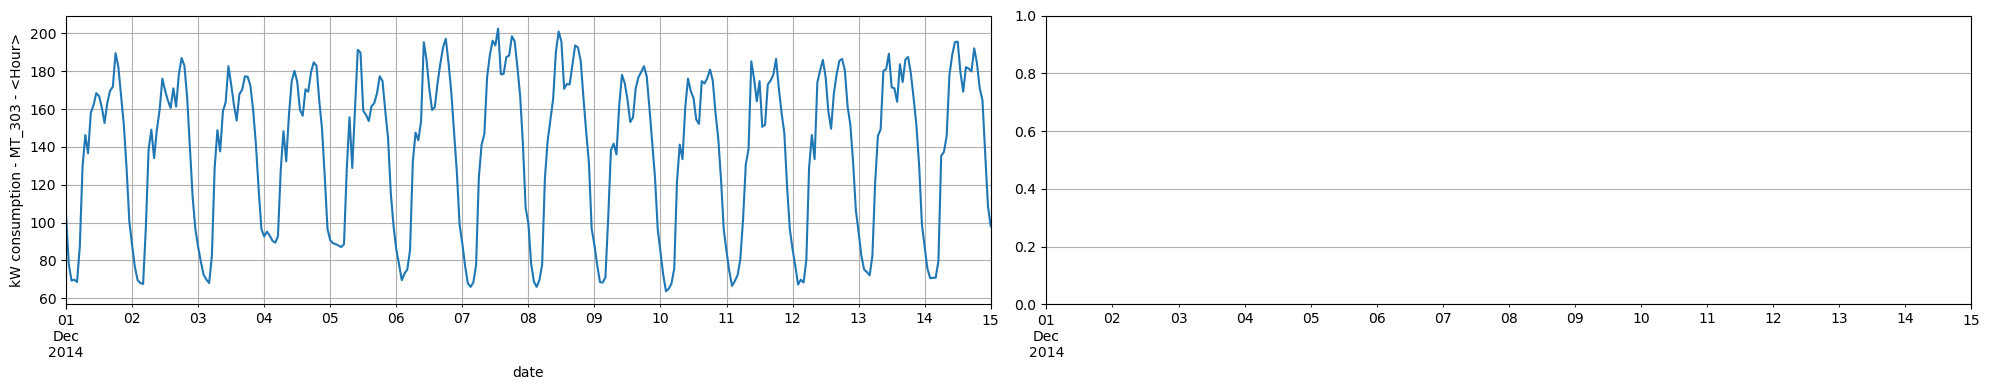

In [28]:
if data_kw_sample.shape[1] > MAX_TS_TO_DISPLAY:
    print(f"\033[91mToo many time series in the dataset to visualize, displaying a random sample of {MAX_TS_TO_DISPLAY}.\033[0m")
    sample = data_kw_sample.sample(n=MAX_TS_TO_DISPLAY, axis=1)
else:
    sample = data_kw_sample
    
plot_timeseries(
    [np.trim_zeros(sample.iloc[:, i], trim="f") for i in range(sample.shape[1])],
    pd.Timestamp("2014-12-01"), intervals_per_day*14
)

### Convert data to GluonTS format
A dataset should satisfy minimum requirements to be compartible with GluonTS: it should be an interable collections of data entries/time series, each entry should have at least a `target` field with values of the time series, and a `start` field with the start date of the time series.

To work directly on `pandas.DataFrame` or `pandas.Series`, you can use GluonTS `PandasDataset` class. GluonTS also supports multiple time series – they can be a list of the DataFrames, a dict of DataFrames, or a long format DataFrame with `item_id` column that designates each individual time series.

In [29]:
# take the last year of data for a sample
start_training_date = pd.Timestamp('2014-01-01')
end_dataset_date = pd.Timestamp('2014-12-31')

In [30]:
df_wide = data_kw_sample[(data_kw_sample.index > start_training_date) & (data_kw_sample.index <= end_dataset_date)]

In [31]:
ts_dataset = PandasDataset(dict(df_wide))

In [32]:
ts_dataset

PandasDataset<size=1, freq=h, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>

In [33]:
# See what is inside the PandasDataset
entry = next(iter(ts_dataset))

print(entry)
print(f"Number of data points: {len(entry['target'])}")
print(f"Number of time series in the dataset: {len(ts_dataset)}")

{'start': Period('2014-01-01 01:00', 'h'), 'target': array([ 75.94827586,  77.21855984,  74.42444219, ..., 148.84888438,
        99.80223124,  76.45537525]), 'item_id': 'MT_303'}
Number of data points: 8736
Number of time series in the dataset: 1


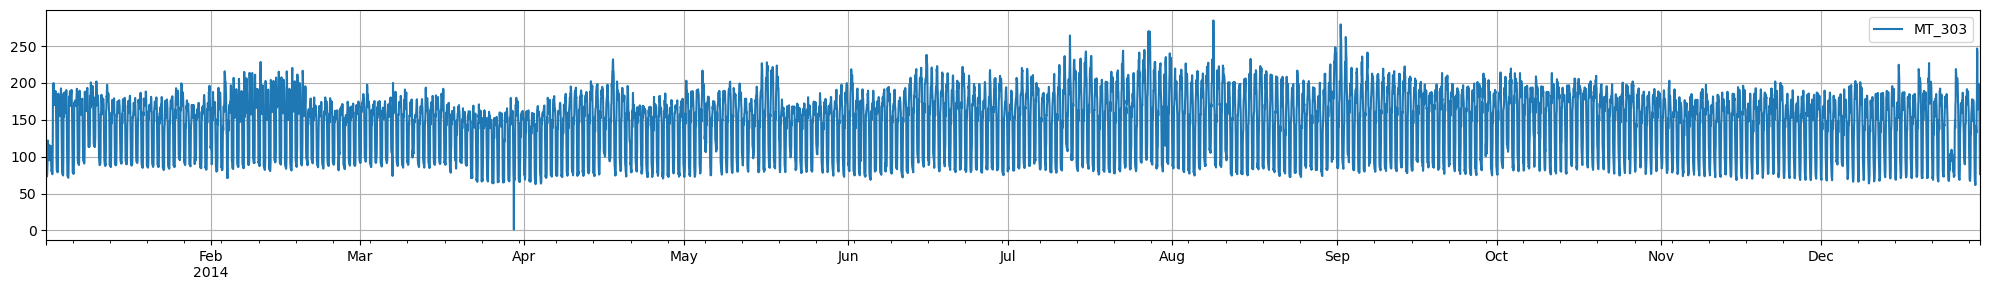

In [34]:
# show time series
for i, entry in enumerate(itertools.islice(ts_dataset, MAX_TS_TO_DISPLAY)):
    to_pandas(entry).plot(label=entry['item_id'], color=colors[i % len(colors)]) 
    plt.legend()
    plt.tight_layout()
    plt.show()

### Split into train and test datasets
Before training, you need to split the dataset to training and test parts. You can use a built-in [`splitter`](https://ts.gluon.ai/stable/api/gluonts/gluonts.dataset.split.html) to implement different strategies to split a given dataset. You can use [`OffsetSplitter`](https://ts.gluon.ai/stable/api/gluonts/gluonts.dataset.split.html#gluonts.dataset.split.OffsetSplitter) to split a uniform dataset by time step offset or [`DateSplitter`](https://ts.gluon.ai/stable/api/gluonts/gluonts.dataset.split.html#gluonts.dataset.split.DateSplitter) to split based on a specific date.

To generate and handle test pairs containing the test input and ground truth data, you can use [`TestTemplate`](https://ts.gluon.ai/stable/api/gluonts/gluonts.dataset.split.html#gluonts.dataset.split.TestTemplate) helper class.

Refer to the GluonTS API documentation for [`gluonts.dataset.split`](https://ts.gluon.ai/stable/api/gluonts/gluonts.dataset.split.html#) module for other helpful constructs and utilities.

In [35]:
# define some visualization helpers
def highlight_entry(entry, color, ax):
    start = entry["start"]
    end = entry["start"] + len(entry["target"])
    ax.axvspan(start, end, facecolor=color, alpha=0.2)

def plot_dataset_splitting(
    original_dataset, 
    training_dataset, 
    test_pairs
):
    n_rows = min(len(original_dataset), MAX_TS_TO_DISPLAY) + min(len(test_pairs), 2*MAX_TS_TO_DISPLAY)
    fig, axes = plt.subplots(n_rows, 1, figsize=(15, 3*n_rows))
    axes = axes.flatten()  # Convert 2D array of axes to 1D for easier indexing

    if len(original_dataset) > MAX_TS_TO_DISPLAY or len(test_pairs) > 2*MAX_TS_TO_DISPLAY:
        print(f"\033[91mToo many time series in the dataset to visualize, displaying first {MAX_TS_TO_DISPLAY} time series.\033[0m")

    # Current subplot index
    current_ax = 0
    
    # Plot original dataset and highlight the training part
    for original_entry, train_entry in zip(itertools.islice(original_dataset, MAX_TS_TO_DISPLAY), itertools.islice(training_dataset, MAX_TS_TO_DISPLAY)):
        ax = axes[current_ax]
        start = original_entry['start'].to_timestamp()
        end = (original_entry['start'] + len(original_entry['target'])).to_timestamp()
        to_pandas(original_entry).plot(ax=ax)
        highlight_entry(train_entry, "red", ax)
        ax.legend([f"original dataset: {train_entry['item_id']}", "training dataset"], loc="upper left")
        current_ax += 1

    # Plot test pairs
    for test_input, test_label in itertools.islice(test_pairs, 2*MAX_TS_TO_DISPLAY):
        ax = axes[current_ax]
        to_pandas(test_input).plot(ax=ax)
        to_pandas(test_label).plot(ax=ax)
        highlight_entry(test_input, "green", ax)
        highlight_entry(test_label, "blue", ax)
        ax.set_xlim(start, end)
        ax.legend([f"test input: {test_input['item_id']}", "test label", "input", "label"], loc="upper left")
        current_ax += 1
        
    plt.tight_layout()
    plt.show()

#### Example 1: split by offset

In [36]:
# Split by offset
NUM_WINDOWS = 2 # you define how many test windows should be generated for each time series

train_ds, test_template = OffsetSplitter(offset=-NUM_WINDOWS*prediction_length).split(ts_dataset)
test_pairs = test_template.generate_instances(
    prediction_length=prediction_length, 
    windows=NUM_WINDOWS, 
)

In [37]:
print(f"The dataset is splitted in {len(train_ds)} training datasets and {len(test_pairs)} test pairs")

The dataset is splitted in 1 training datasets and 2 test pairs


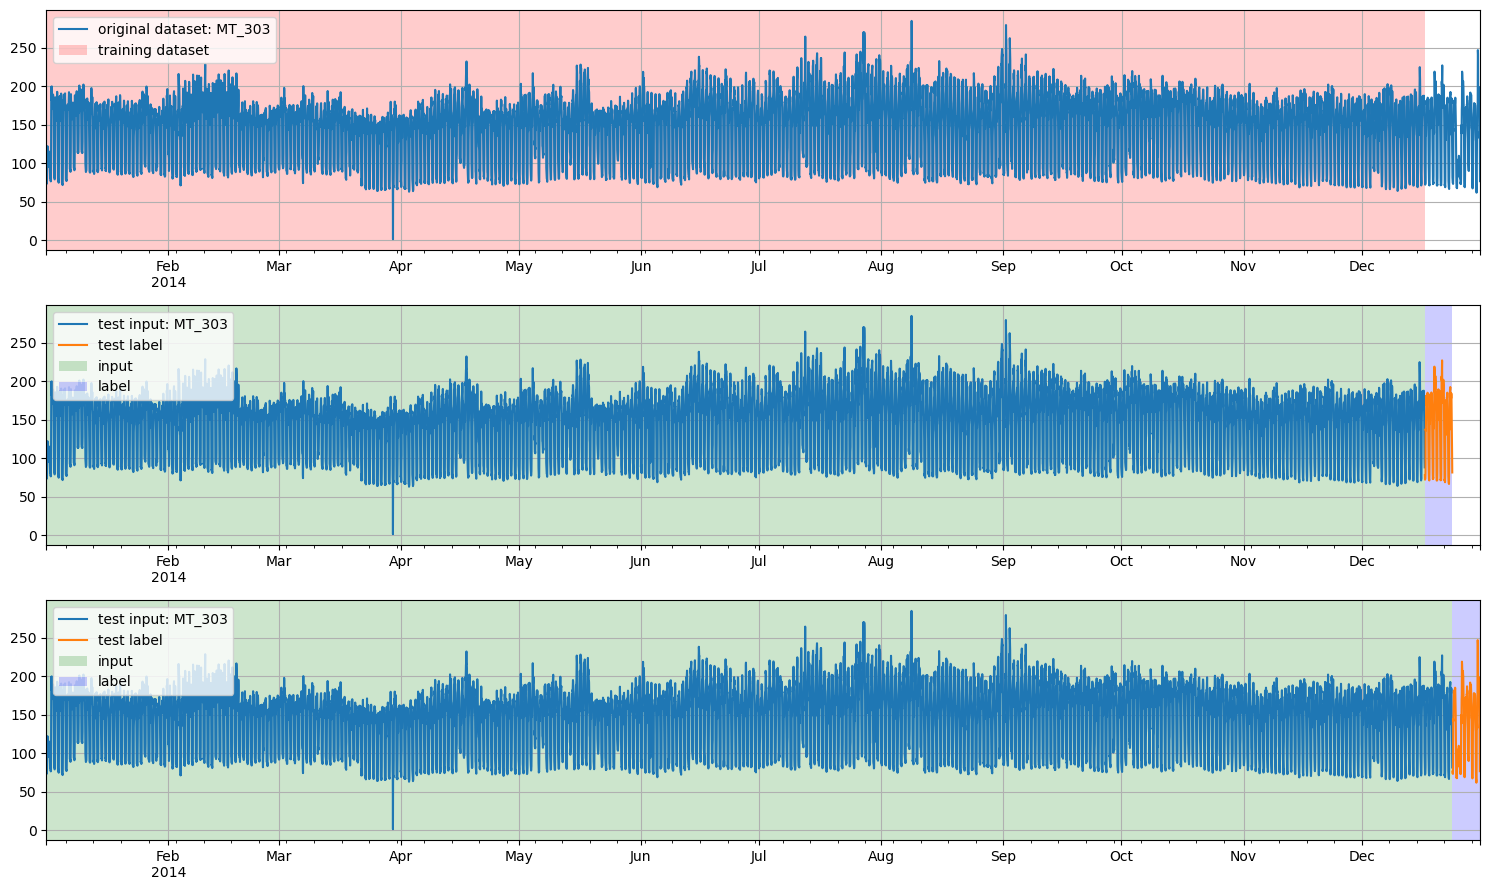

In [38]:
# visualize
plot_dataset_splitting(ts_dataset, train_ds, test_pairs)

#### Example 2: split by date

In [39]:
# Split by date
NUM_WINDOWS = 4
end_training_date = pd.Period(end_dataset_date, freq=freq) - NUM_WINDOWS*prediction_length

train_ds, test_template = DateSplitter(date=end_training_date).split(ts_dataset)
test_pairs = test_template.generate_instances(
    prediction_length=prediction_length,
    windows=NUM_WINDOWS,
    distance=prediction_length//2, # using 'distance' argument you can make windows overlap
)

In [40]:
print(f"The dataset is splitted in {len(train_ds)} training datasets and {len(test_pairs)} test pairs")

The dataset is splitted in 1 training datasets and 4 test pairs


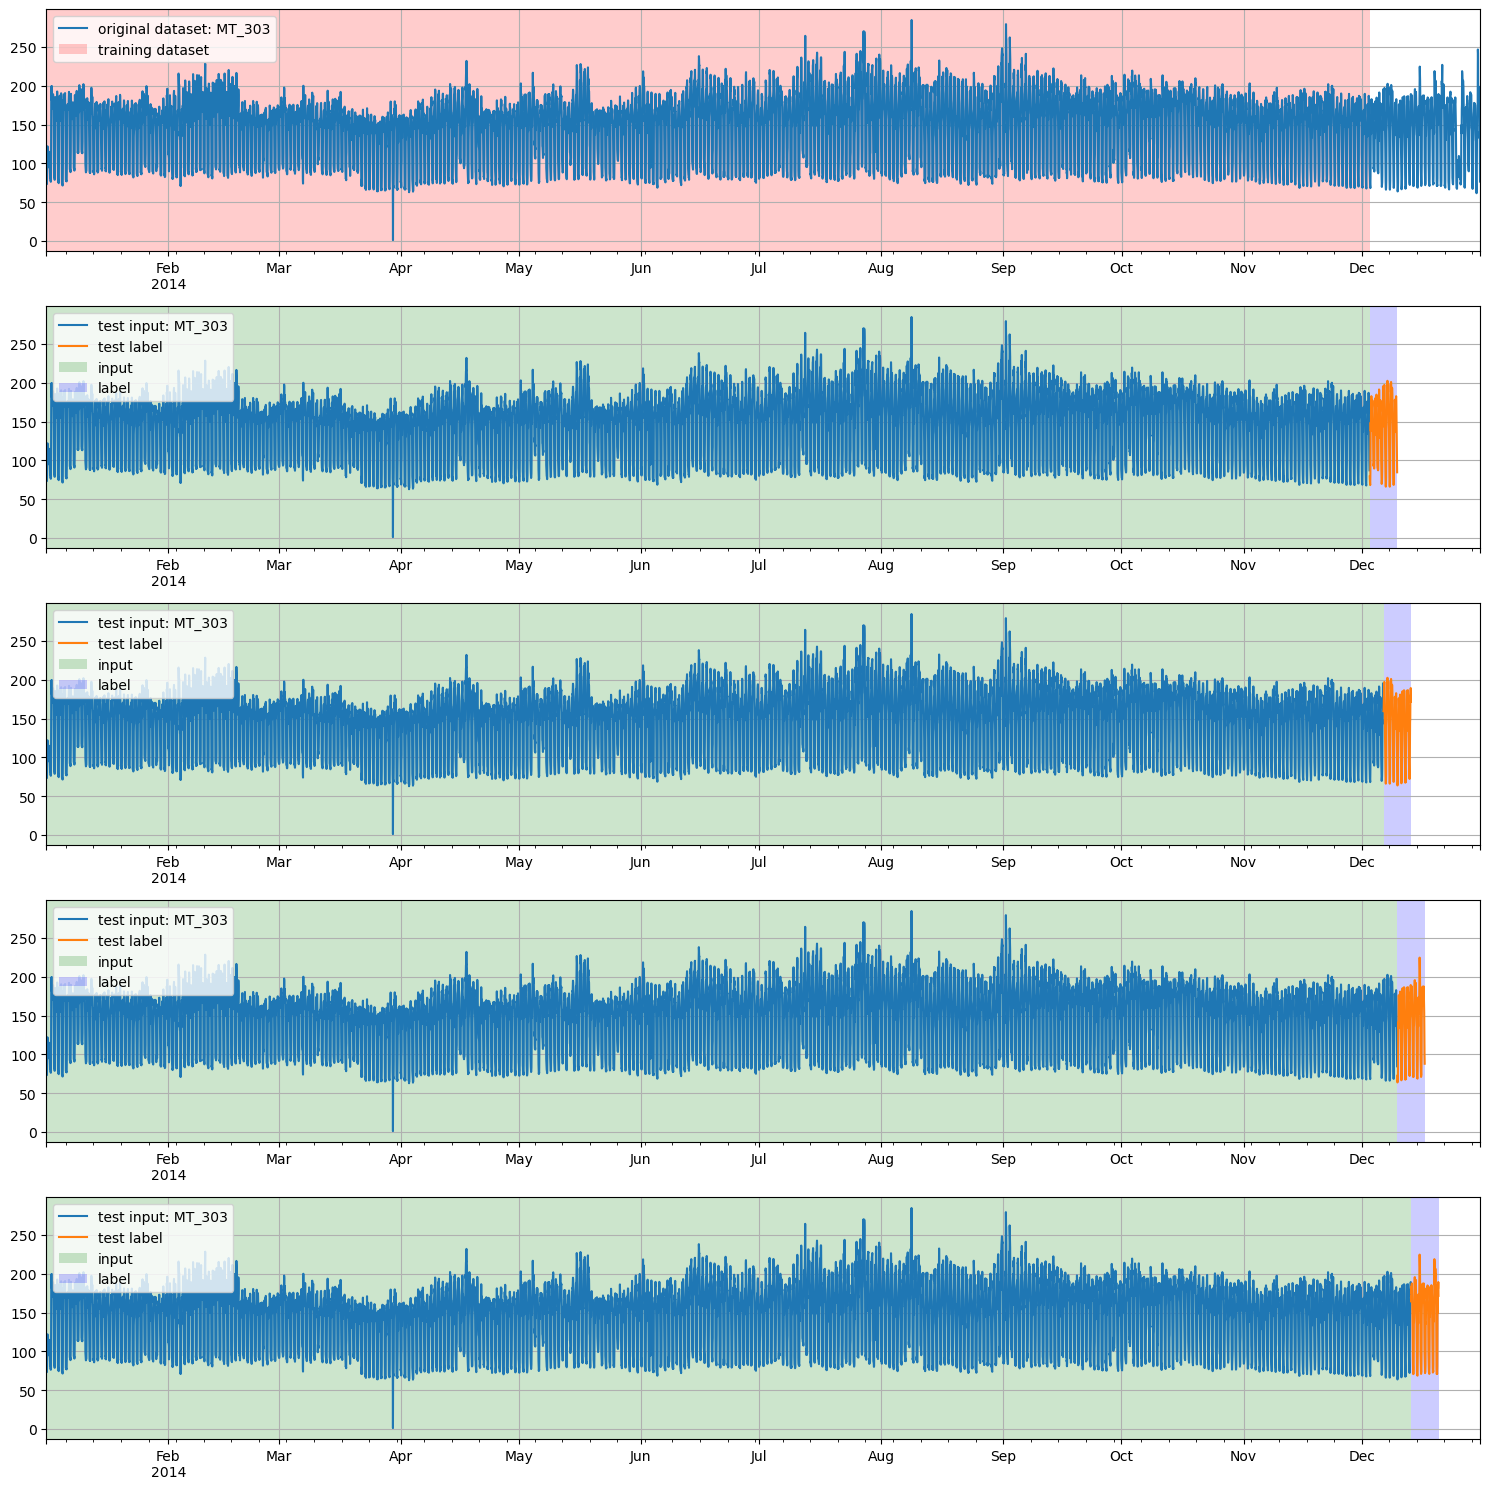

In [41]:
plot_dataset_splitting(ts_dataset, train_ds, test_pairs)

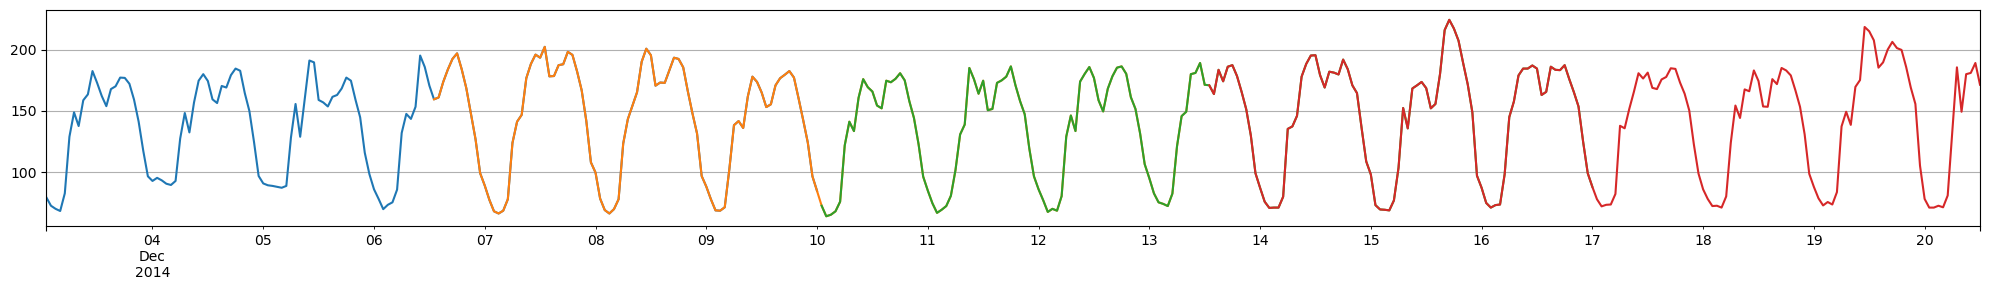

In [42]:
# visualize only ground truth (label) for each testing window
for _, test_label in itertools.islice(test_pairs, MAX_TS_TO_DISPLAY):
    to_pandas(test_label).plot()

plt.tight_layout()
plt.show()

### Training an existing model
This section uses a single sample time series to demonstrate the prosess of training a model, producing predictions, and evaluating the results.

To encapsulate models and trained model artifacts, GluonTS uses an `Estimator`/`Predictor` pair of abstractions that should be familiar to users of other machine learning frameworks. An `Estimator` represents a model that can be trained on a dataset to yield a `Predictor`, which can later be used to make predictions on unseen data.

#### Example 1: Seasonal Naive
First make prediction using a simple seasonal model.

For each time series $Y$ the seasonal naive predictor produces a forecast:

$\tilde{Y}(T+k) = Y(T+k-h)$

where $T$ - forecast time, $k$ - prediction length-1, $h$ - season length 

In [43]:
# split the dataset at the last two weeks of the year and predict the week before last to avoid the one-off effect of the Dec 25th
train_ds, test_template = OffsetSplitter(offset=-2*prediction_length).split(ts_dataset)
test_pairs = test_template.generate_instances(
    prediction_length=prediction_length, 
    windows=1, 
)

print(f"The dataset is splitted in {len(train_ds)} training datasets and {len(test_pairs)} test pairs")

The dataset is splitted in 1 training datasets and 1 test pairs


In [44]:
# create instance of predictor
seasonal_naive_predictor = SeasonalNaivePredictor(
    prediction_length=prediction_length,
    season_length=24,
)

In [45]:
# predict
forecasts = [seasonal_naive_predictor.predict_item(test_input) for test_input, _ in test_pairs]

In [46]:
forecast_entry = forecasts[0]

print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 1
Dimension of samples: (1, 168)
Start date of the forecast window: 2014-12-17 01:00
Frequency of the time series: <Hour>


In [47]:
# access to predictions
forecast_entry.mean

array([ 74.67799,  70.87221,  72.90568,  73.41024,  98.28093, 144.97719,
       157.74847, 179.11005, 184.70589, 184.70589, 187.249  , 184.70589,
       163.09077, 165.63133, 186.23225, 183.68915, 183.4356 , 187.50507,
       176.05984, 165.37779, 153.679  , 124.82758,  99.04158,  87.87779,
        74.67799,  70.87221,  72.90568,  73.41024,  98.28093, 144.97719,
       157.74847, 179.11005, 184.70589, 184.70589, 187.249  , 184.70589,
       163.09077, 165.63133, 186.23225, 183.68915, 183.4356 , 187.50507,
       176.05984, 165.37779, 153.679  , 124.82758,  99.04158,  87.87779,
        74.67799,  70.87221,  72.90568,  73.41024,  98.28093, 144.97719,
       157.74847, 179.11005, 184.70589, 184.70589, 187.249  , 184.70589,
       163.09077, 165.63133, 186.23225, 183.68915, 183.4356 , 187.50507,
       176.05984, 165.37779, 153.679  , 124.82758,  99.04158,  87.87779,
        74.67799,  70.87221,  72.90568,  73.41024,  98.28093, 144.97719,
       157.74847, 179.11005, 184.70589, 184.70589, 

In [48]:
# for seasonal naive all quantiles are the same
forecast_entry.quantile(0.9)

array([ 74.67799,  70.87221,  72.90568,  73.41024,  98.28093, 144.97719,
       157.74847, 179.11005, 184.70589, 184.70589, 187.249  , 184.70589,
       163.09077, 165.63133, 186.23225, 183.68915, 183.4356 , 187.50507,
       176.05984, 165.37779, 153.679  , 124.82758,  99.04158,  87.87779,
        74.67799,  70.87221,  72.90568,  73.41024,  98.28093, 144.97719,
       157.74847, 179.11005, 184.70589, 184.70589, 187.249  , 184.70589,
       163.09077, 165.63133, 186.23225, 183.68915, 183.4356 , 187.50507,
       176.05984, 165.37779, 153.679  , 124.82758,  99.04158,  87.87779,
        74.67799,  70.87221,  72.90568,  73.41024,  98.28093, 144.97719,
       157.74847, 179.11005, 184.70589, 184.70589, 187.249  , 184.70589,
       163.09077, 165.63133, 186.23225, 183.68915, 183.4356 , 187.50507,
       176.05984, 165.37779, 153.679  , 124.82758,  99.04158,  87.87779,
        74.67799,  70.87221,  72.90568,  73.41024,  98.28093, 144.97719,
       157.74847, 179.11005, 184.70589, 184.70589, 

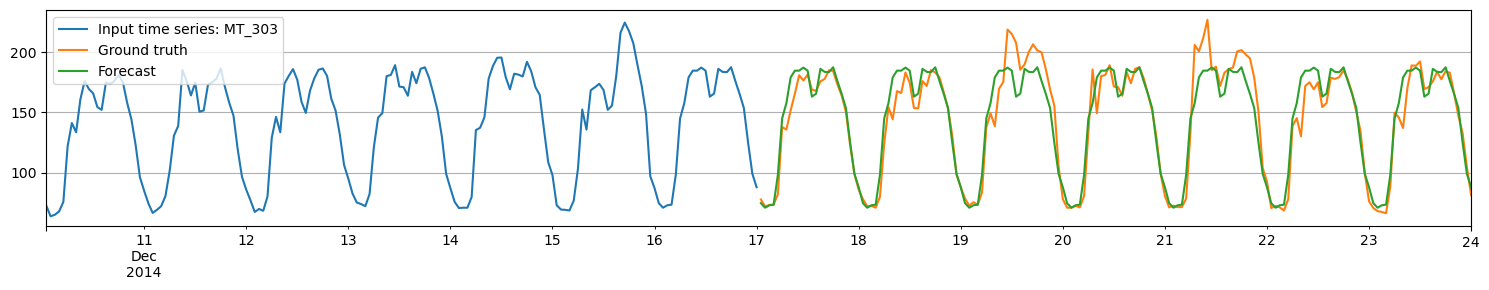

In [49]:
# visualize predictions
i = 0
for test_input, test_label in itertools.islice(test_pairs, MAX_TS_TO_DISPLAY):
    fig, ax = plt.subplots(1, 1, figsize=(15,3))

    to_pandas(test_input)[-prediction_length:].plot(ax=ax, label=f"Input time series: {test_input['item_id']}")
    to_pandas(test_label).plot(ax=ax, label="Ground truth")
    mean_forecast = forecasts[i].to_quantile_forecast(['mean'])
    pd.Series(data=mean_forecast.forecast_array[0], index=mean_forecast.index).plot(ax=ax, label="Forecast")
    i += 1

    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

#### Evaluate predictions
Use GluonTS [`Evaluator`](https://ts.gluon.ai/stable/api/gluonts/gluonts.evaluation.html) class to evaluate the forecast numerically. This class computes metrics per time series (item) as well as aggregated metrics accross all time series.

In [50]:
evaluator = Evaluator(quantiles=[0.5])
agg_metrics, item_metrics = evaluator(
    [to_pandas(l) for l in test_pairs.label], 
    forecasts,
    num_series=len(ts_dataset),
)

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]


In [51]:
# aggregated metrics
print(json.dumps(agg_metrics, indent=2))

{
  "MSE": 207.03423685779367,
  "abs_error": 1658.886968136796,
  "abs_target_sum": 24272.527890466532,
  "abs_target_mean": 144.4793326813484,
  "seasonal_error": NaN,
  "MASE": NaN,
  "MAPE": 0.06821669226559132,
  "sMAPE": 0.0668570881732473,
  "MSIS": NaN,
  "num_masked_target_values": 0.0,
  "QuantileLoss[0.5]": 1658.886968136796,
  "Coverage[0.5]": 0.5773809523809523,
  "RMSE": 14.38868433380181,
  "NRMSE": 0.09958991411966371,
  "ND": 0.06834421925984699,
  "wQuantileLoss[0.5]": 0.06834421925984699,
  "mean_absolute_QuantileLoss": 1658.886968136796,
  "mean_wQuantileLoss": 0.06834421925984699,
  "MAE_Coverage": 0.07738095238095233,
  "OWA": NaN
}


In [52]:
# metrics per time series
item_metrics

item_id    forecast_start         MSE    abs_error  abs_target_sum  \
0  MT_303  2014-12-17 01:00  207.034237  1658.886968     24272.52789   

   abs_target_mean  seasonal_error  MASE      MAPE     sMAPE  \
0       144.479333             NaN   NaN  0.068217  0.066857   

   num_masked_target_values        ND  MSIS  QuantileLoss[0.5]  Coverage[0.5]  
0                       0.0  0.068344   NaN        1658.886968       0.577381

In [53]:
def visualize_item_metric(
    item_metrics,
    metric_name,
):
    fig, ax = plt.subplots(figsize=(15,6))

    metric_data = item_metrics[metric_name]
    ax.bar(item_metrics['item_id'], metric_data)

    if len(item_metrics) > 1:
        avg = metric_data.mean()
        std = metric_data.std()
        # Add average line
        ax.axhline(avg, color='red', linestyle='--', label='Average')
        # Add shaded area for standard deviation
        ax.fill_between(range(len(item_metrics)), avg - std, avg + std, color='green', alpha=0.2, label='±1 Std Dev')
    
    ax.set_title(f'{metric_name} per item')
    ax.set_ylabel(metric_name)
    
    # Show only horizontal grid lines
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    ax.legend()
    plt.xticks(rotation='vertical')
    plt.tight_layout()
    plt.show()

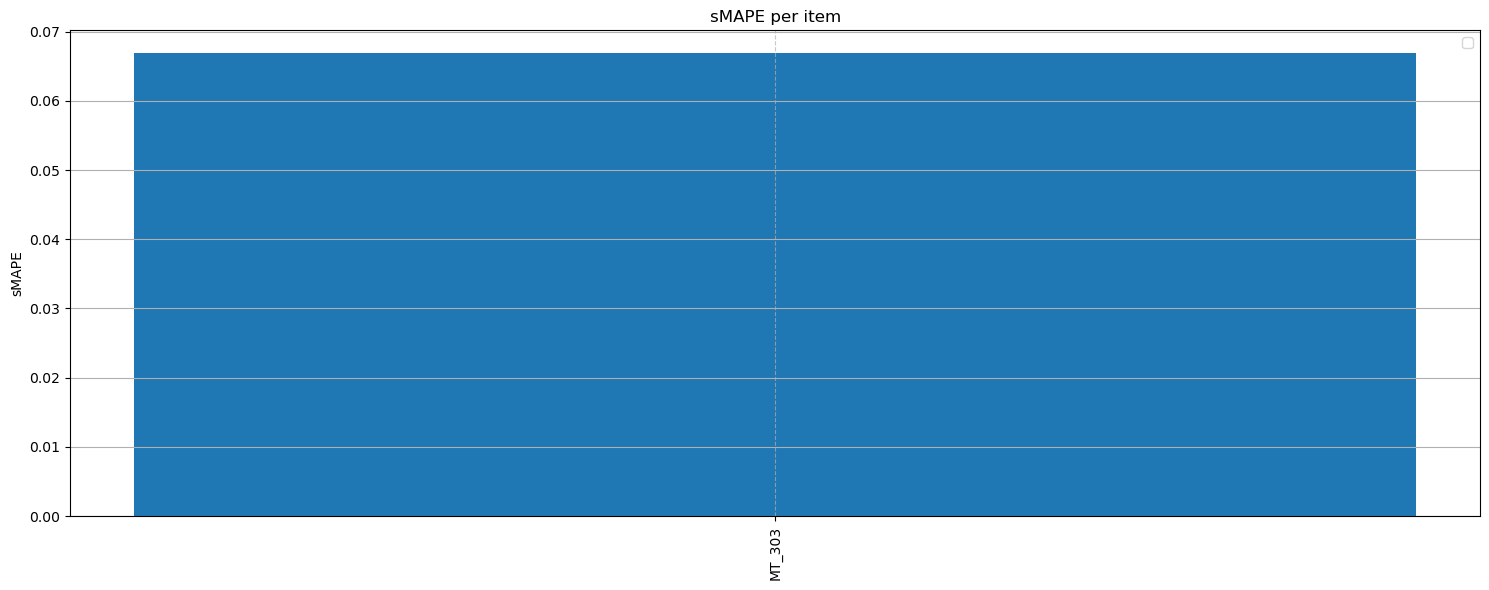

In [54]:
visualize_item_metric(item_metrics, 'sMAPE')

#### Example 2: feedforward network
Now use GluonTS's built-in fundamental neural network model [`SimpleFeedForwardEstimator`](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/simple_feedforward/_estimator.py).

`SimpleFeedForwardEstimator` implements a Multilayer Perceptron (MLP) model that predicts future time steps based on previous observations. The model produces probabilistic forecasts, meaning it outputs probability distributions rather than single point estimates.

To make forecast generation and evaluation easier, you can use GluonTS helper function
[`make_evaluation_predictions`](https://ts.gluon.ai/stable/api/gluonts/gluonts.evaluation.html#gluonts.evaluation.make_evaluation_predictions). This function performs the following:
1. Removes the last window of `prediction_length` data points from the dataset
2. The estimator predicts the future `prediction_length` data points starting from the last point in the dataset
3. Outputs the forecast samples and the input dataset

In [55]:
train_ds, _ = OffsetSplitter(offset=-prediction_length).split(ts_dataset)

In [56]:
feed_forward_estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=prediction_length,
    context_length=4*prediction_length,
    trainer=Trainer(ctx="cpu", epochs=5, learning_rate=1e-3, num_batches_per_epoch=100),
)

In [57]:
feed_forward_predictor = feed_forward_estimator.train(train_ds)

100%|██████████| 100/100 [00:02<00:00, 35.92it/s, epoch=5/5, avg_epoch_loss=4.28]


In [58]:
# predict the last prediction_length data points of the dataset
forecast_it, ts_it = make_evaluation_predictions(
    dataset=ts_dataset, 
    predictor=feed_forward_predictor,
    num_samples=20
)

In [59]:
forecasts = list(forecast_it)
labels = list(ts_it)

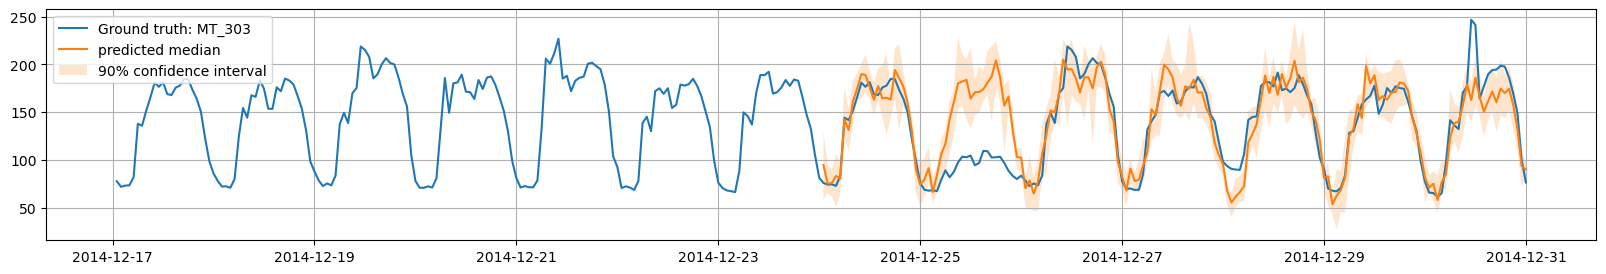

In [60]:
# visualize predictions
for i, forecast in enumerate(itertools.islice(forecasts, MAX_TS_TO_DISPLAY)):
    plt.plot(labels[i][-2*prediction_length:].to_timestamp())
    forecast.plot(intervals=(0.9,), show_label=True)
    plt.legend([f"Ground truth: {forecast.item_id}", "predicted median", "90% confidence interval"])
    plt.show()

#### Evaluate predictions

In [61]:
evaluator = Evaluator(quantiles=(np.arange(10) / 10.0)[1:])
agg_metrics, item_metrics = evaluator(
    labels, 
    forecasts,
    num_series=len(ts_dataset),
)

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


In [62]:
print(json.dumps(agg_metrics, indent=2))

{
  "MSE": 790.1019439438389,
  "abs_error": 3154.3105810293036,
  "abs_target_sum": 22897.87778904665,
  "abs_target_mean": 136.29689160146816,
  "seasonal_error": 8.99114018306856,
  "MASE": 2.08823996046346,
  "MAPE": 0.16291315011538204,
  "sMAPE": 0.14370358742166062,
  "MSIS": 27.434349581081857,
  "num_masked_target_values": 0.0,
  "QuantileLoss[0.1]": 2320.8258557750996,
  "Coverage[0.1]": 0.20238095238095238,
  "QuantileLoss[0.2]": 2830.179769092737,
  "Coverage[0.2]": 0.30952380952380953,
  "QuantileLoss[0.3]": 3142.994974474488,
  "Coverage[0.3]": 0.38095238095238093,
  "QuantileLoss[0.4]": 3197.7718019311333,
  "Coverage[0.4]": 0.4583333333333333,
  "QuantileLoss[0.5]": 3154.3105810293036,
  "Coverage[0.5]": 0.5357142857142857,
  "QuantileLoss[0.6]": 2973.22086155951,
  "Coverage[0.6]": 0.5714285714285714,
  "QuantileLoss[0.7]": 2633.425043677892,
  "Coverage[0.7]": 0.6547619047619048,
  "QuantileLoss[0.8]": 2121.680185060323,
  "Coverage[0.8]": 0.75,
  "QuantileLoss[0.9]":

In [63]:
item_metrics

item_id    forecast_start         MSE    abs_error  abs_target_sum  \
0  MT_303  2014-12-24 01:00  790.101944  3154.310581    22897.877789   

   abs_target_mean  seasonal_error     MASE      MAPE     sMAPE  ...  \
0       136.296892         8.99114  2.08824  0.162913  0.143704  ...   

   QuantileLoss[0.5]  Coverage[0.5]  QuantileLoss[0.6]  Coverage[0.6]  \
0        3154.310581       0.535714        2973.220862       0.571429   

   QuantileLoss[0.7]  Coverage[0.7]  QuantileLoss[0.8]  Coverage[0.8]  \
0        2633.425044       0.654762        2121.680185           0.75   

   QuantileLoss[0.9]  Coverage[0.9]  
0        1446.077817       0.821429  

[1 rows x 31 columns]

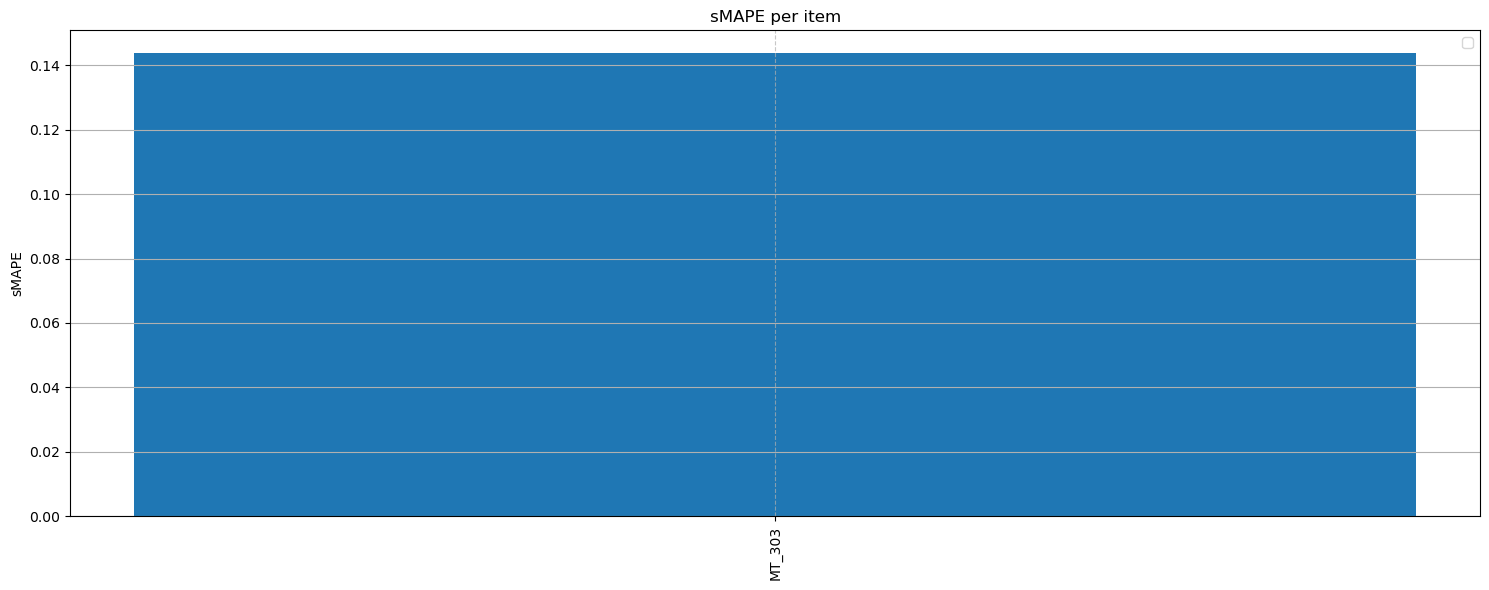

In [64]:
visualize_item_metric(item_metrics, 'sMAPE')

---

## Train GluonTS models: advanced usage

After learning some basic approaches to train and evaluate simple GluonTS models, you move to training of more advanced models.

### Prepare dataset
In this section you select time series and an inteval for training and evaluation.

#### Choose time series
Select the full dataset with all time series or only a subset of random or specific time series for training and evaluation.

<div class="alert alert-info">
To reduce the training time and inference time you can use a subset of time series instead of the full dataset with 370 time series.
</div>

In [65]:
USE_FULL_DATASET = False # The training of full dataset can take about 40 minutes per estimator
SAMPLE_SIZE = 10 # set number of samples in the dataset if you don't use the full dataset
MAX_TS_TO_DISPLAY = 5 # maximum number of displayed time series plots

In [66]:
# get the full dataset or a random sample of SAMPLE_SIZE
# you can change the selection to include specific time series
# ts_sample = data_kw[['item_id1', 'item_id2']]
ts_sample = data_kw if USE_FULL_DATASET else data_kw[np.random.choice(data_kw.columns.to_list(), size=SAMPLE_SIZE, replace=False)]

#### Choose start and end dates
Select the time interval for training and evaluation. Use the following visualization to choose your specific interval.

In [67]:
start_training_date = pd.Timestamp('2014-01-01')
end_dataset_date = pd.Timestamp('2014-12-31')

In [68]:
style = {"description_width": "initial"}
item_ids = ts_sample.columns.to_list()

In [69]:
@interact_manual(
    item_ids=SelectMultiple(options=item_ids,value=[item_ids[0]], rows=5, style=style, description='Time series ids:'),
    data_start=DatePicker(value=start_training_date, style=style, description='Data start:'),
    data_end=DatePicker(value=end_dataset_date, style=style, description='Data end:'),
    continuous_update=False,
)
def plot_interact(item_ids, data_start, data_end):

    print(f'Filtering and displaying the data from {data_start} to {data_end}')
    ts = ts_sample[(ts_sample.index > pd.Timestamp(data_start)) & (ts_sample.index <= pd.Timestamp(data_end))]

    for i, item in enumerate(itertools.islice(item_ids, 2*MAX_TS_TO_DISPLAY)):
        ts[item].plot(label=item, color=colors[i % len(colors)])
        
        plt.legend()
        plt.tight_layout()
        plt.show()

interactive(children=(SelectMultiple(description='Time series ids:', index=(0,), options=('MT_158', 'MT_264', …

#### Convert to GluonTS format

<div class="alert alert-info">
If you want to use your own custom start and end dates, set them in the next code cell.
</div>

In [70]:
# set interval start and end to your preferred dates
start_training_date = pd.Timestamp('2014-01-01')
end_dataset_date = pd.Timestamp('2014-12-31')

In [71]:
ts_dataset = PandasDataset(
    dict(ts_sample[(ts_sample.index > start_training_date) & (ts_sample.index <= end_dataset_date)])
)

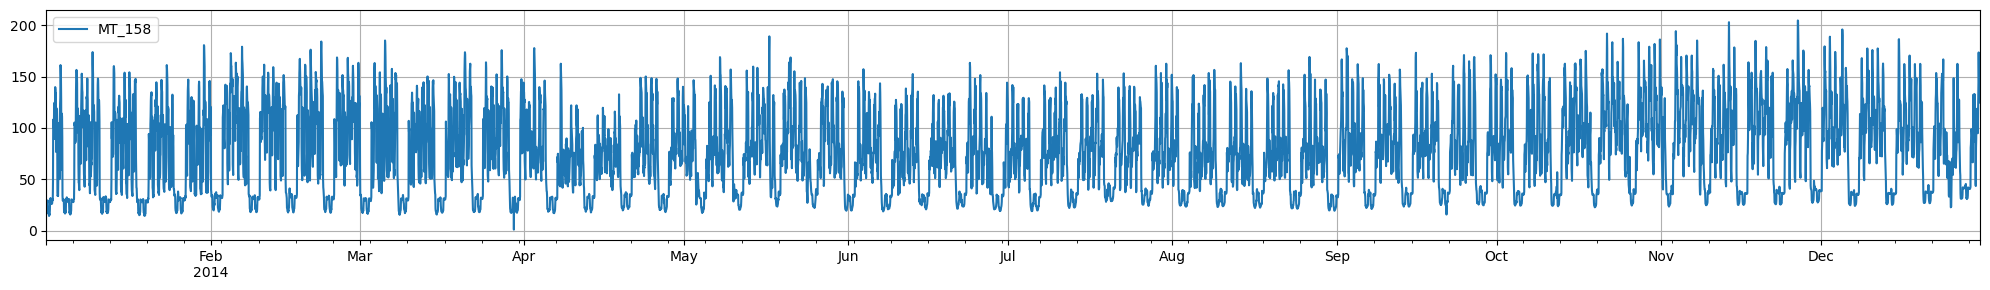

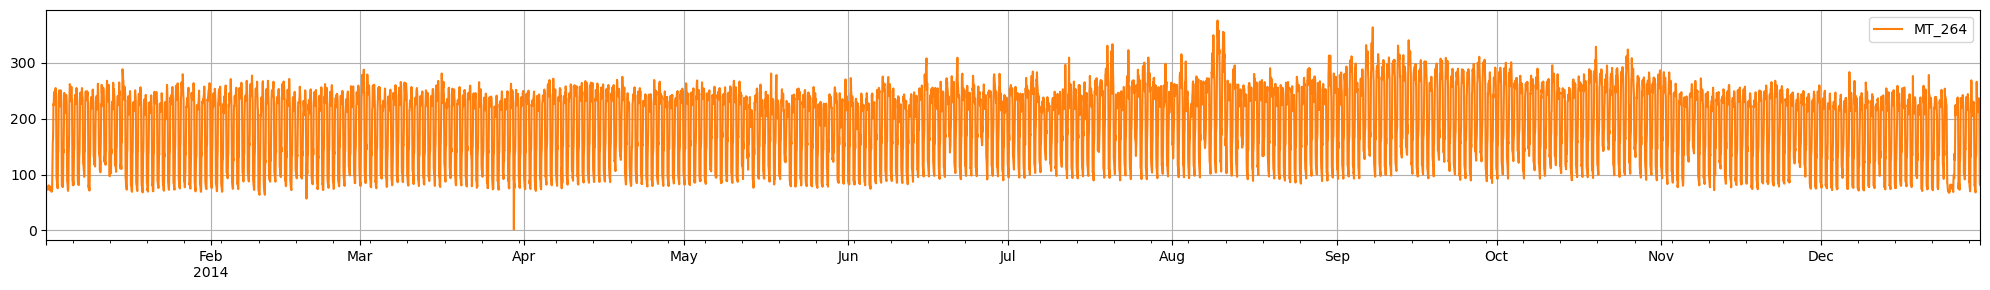

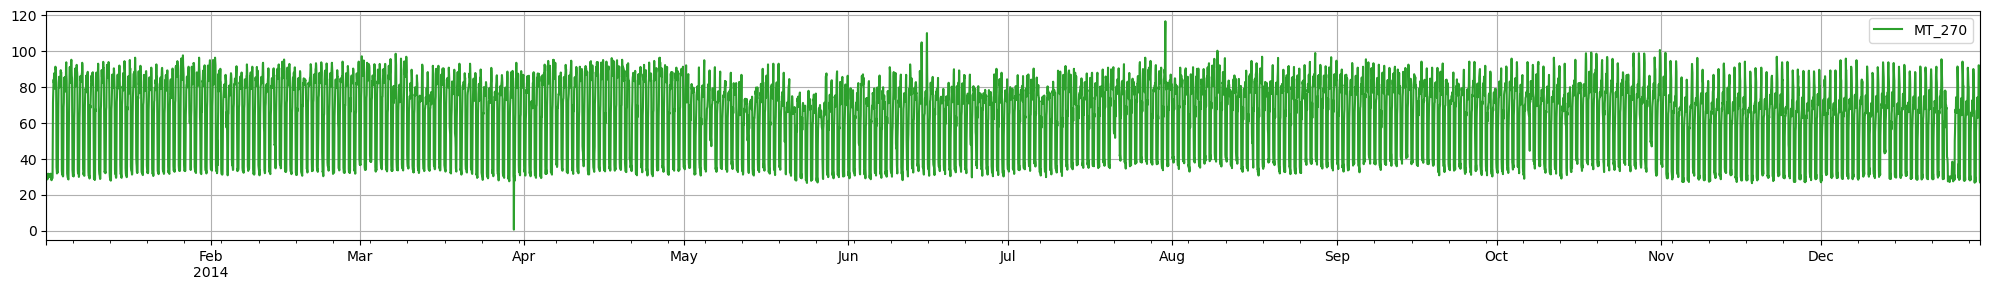

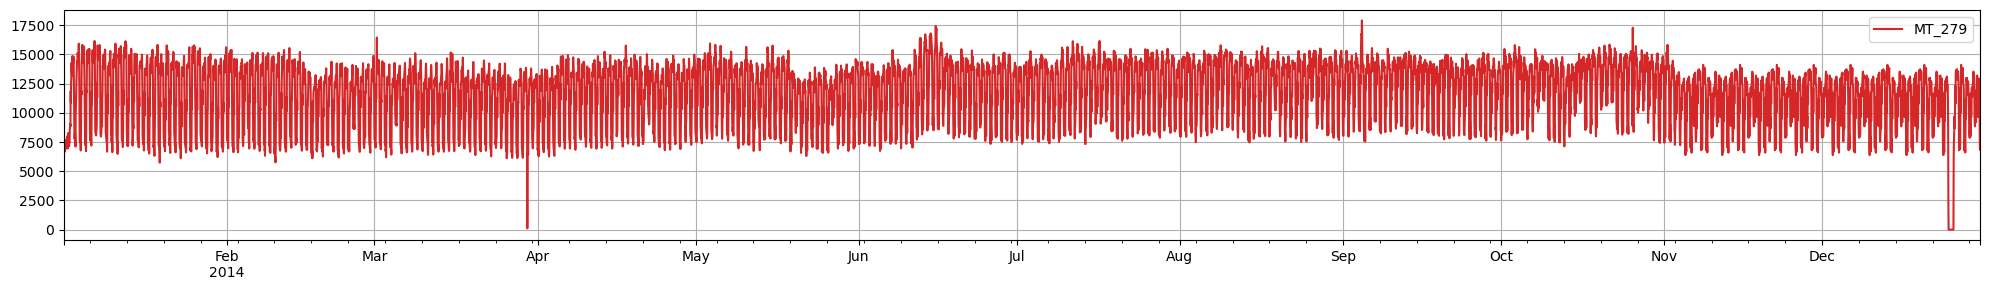

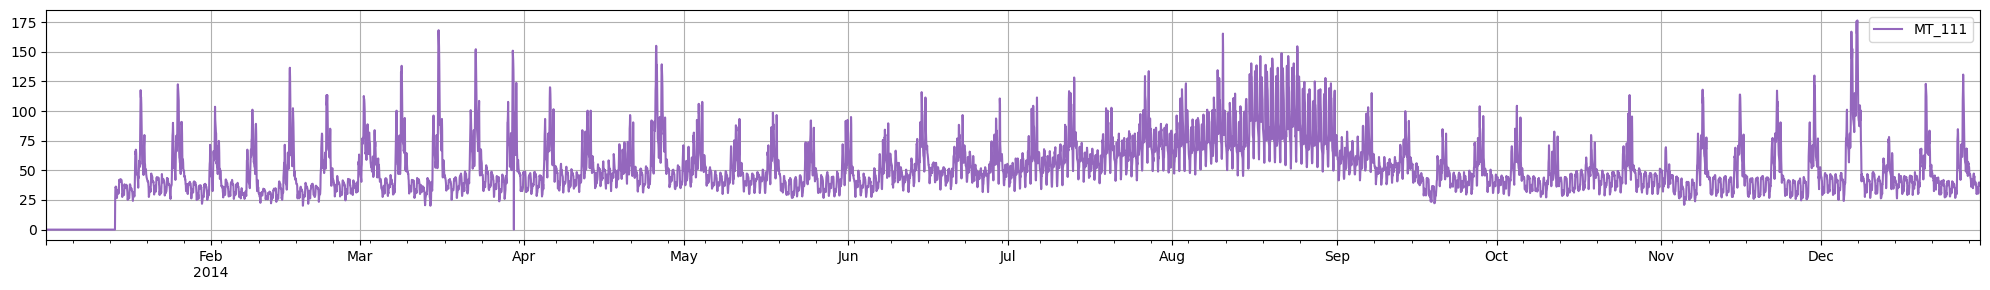

In [72]:
# show time series in the GluonTS dataset
for i, entry in enumerate(itertools.islice(ts_dataset, MAX_TS_TO_DISPLAY)):
    to_pandas(entry).plot(label=entry['item_id'], color=colors[i % len(colors)]) 
    plt.legend()
    plt.tight_layout()
    plt.show()

In [73]:
print(f'The GluonTS dataset contains {len(ts_dataset)} individual time series from {start_training_date} to {end_dataset_date}')

The GluonTS dataset contains 10 individual time series from 2014-01-01 00:00:00 to 2014-12-31 00:00:00


### Split and prepare test instances

For training and test you split data in multiple rolling windows starting from the end of the training dataset. You can choose the number of windows and whether windows overlap with each other.

In [74]:
# set backtest parameters
NUM_WINDOWS = 4 # number of rolling windows for backtest
# distance between windows, set to:
# < prediction_length for overlapping windows
# = prediction length for adjucent windows 
# > prediction_length for non overapping and non-adjucent windows
DISTANCE = prediction_length

# set the training-testing split date
end_training_date = pd.Period(end_dataset_date, freq=freq) - NUM_WINDOWS*prediction_length

In [75]:
train_ds, test_template = DateSplitter(date=end_training_date).split(ts_dataset)
test_pairs = test_template.generate_instances(
    prediction_length=prediction_length,
    windows=NUM_WINDOWS,
    distance=DISTANCE,
)

print(f"The dataset is splitted in {len(train_ds)} training datasets and {len(test_pairs)} test pairs. Training end is {end_training_date}")

The dataset is splitted in 10 training datasets and 40 test pairs. Training end is 2014-12-03 00:00


Too many time series in the dataset to visualize, displaying first 5 time series.


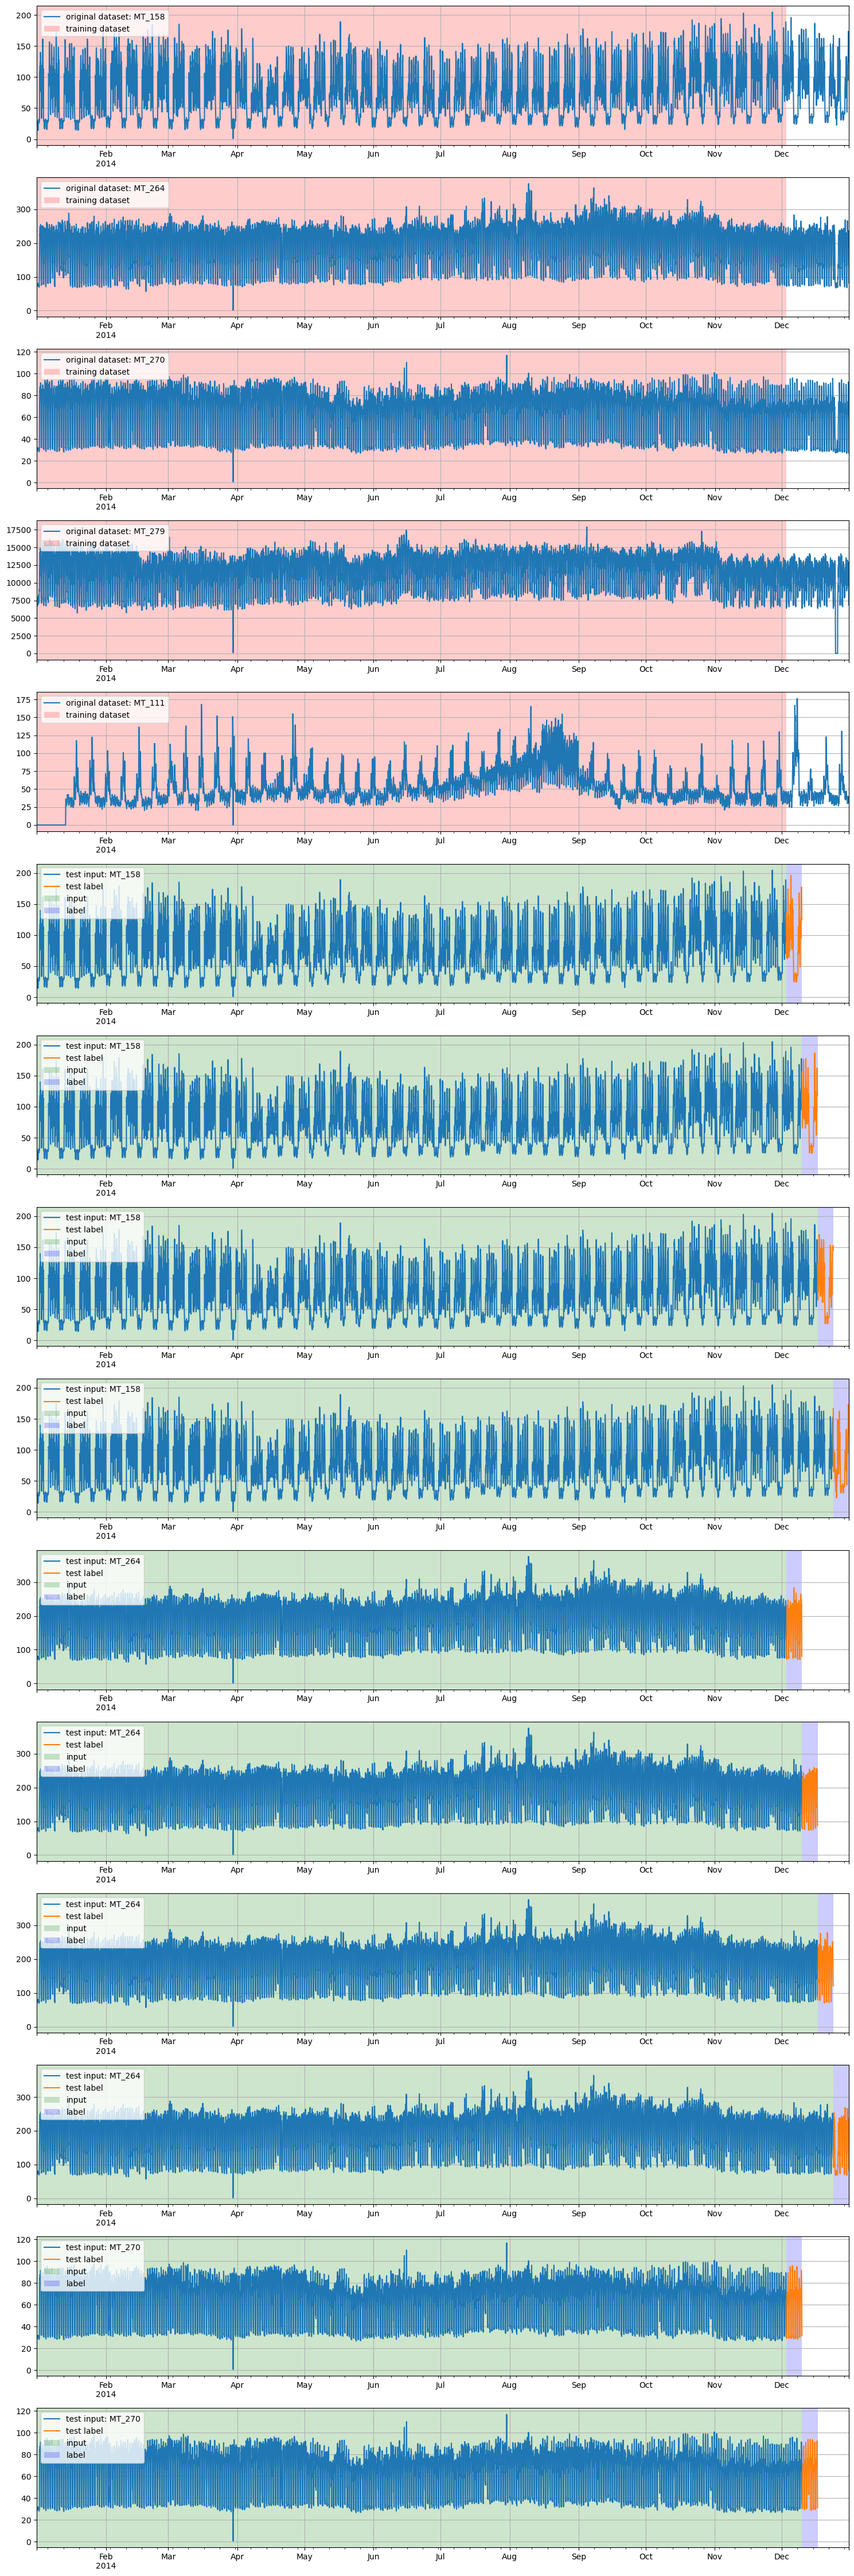

In [76]:
plot_dataset_splitting(ts_dataset, train_ds, test_pairs)

### Train models

Now you're ready to train models. To demonstrate some built-in GluonTS algorithms you going to train the following models:

- [`SimpleFeedForward`](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/simple_feedforward/_estimator.py)
- [`NBEATS`](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/n_beats/_estimator.py), [paper](https://openreview.net/forum?id=r1ecqn4YwB)
- [`DeepAR`](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/deepar/_estimator.py), [paper](https://doi.org/10.1016/j.ijforecast.2019.07.001) 
- [`GaussianProcess`](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/gp_forecaster/_estimator.py)
- [`TemporalFusionTransformer`](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/tft/_estimator.py), [paper](https://doi.org/10.1016/j.ijforecast.2021.03.012)
- [`MQCNN`](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/seq2seq/_mq_dnn_estimator.py), [paper](https://arxiv.org/abs/1711.11053)

To compare performance of these models you're going to use statistical models like [`Seasonal Naive`](https://otexts.com/fpp2/simple-methods.html#seasonal-na%C3%AFve-method), [`Prophet`](https://facebook.github.io/prophet/), and [`NTPS`](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/model/npts/_predictor.py) as a baseline.

You can experiment with other [available models](https://ts.gluon.ai/stable/getting_started/models.html) on your own using the code in this notebook.

In [92]:
# remove an item from this list if you don't want to train that model
estimators_to_train = [
    'SimpleFeedForward', 
    'NBEATS', 
    'DeepAR',
    # 'NBEATSEnsemble',
    'GaussianProcess', 
    'TemporalFusionTransformer', 
    'MQCNN', 
]

<div style="border: 4px solid coral; text-align: left; margin: auto;">
<b>Important considerations</b><br/>
1. This example is not production-grade model training<br/>
2. All estimators are trained with default hyperparameters which might not be the optimal configuration<br/>
3. All training is limited to 8 epochs which might not yield the most optimal model<br/>
4. This notebook uses CPU-only MXNet implementation of all shown neural network models<br/>
5. In a real-world use case you're going to use an ensemble of several models rather than a single model<br/>
</div>

In [93]:
NUM_EPOCHS = 8
# same trainer for all models
trainer = Trainer(
    ctx="cpu",
    epochs=NUM_EPOCHS,
    learning_rate=01e-3,
    clip_gradient=10,
    weight_decay=1e-8,
    num_batches_per_epoch=100
)

In [94]:
estimators = {}

for e in estimators_to_train:
    if e == 'SimpleFeedForward':
        estimators[e] = SimpleFeedForwardEstimator(
            num_hidden_dimensions=[10],
            prediction_length=prediction_length,
            context_length=4*prediction_length,
            trainer=trainer
        )
    elif e == 'NBEATS':
        estimators[e] = NBEATSEstimator(
            freq=freq,
            prediction_length=prediction_length,
            loss_function='MAPE',
            num_stacks=30,
            widths=[512],
            num_blocks=[1],
            trainer=trainer,
        )
    elif e == 'DeepAR':
        estimators[e] = DeepAREstimator(
            freq=freq,
            prediction_length=prediction_length,
            trainer=trainer,
        )
    elif e == 'NBEATSEnsemble':
        # pass
        estimators[e] = NBEATSEnsembleEstimator(
            freq=freq,
            prediction_length=prediction_length,
            trainer=trainer,
        )
    elif e == 'GaussianProcess':
        estimators[e] = GaussianProcessEstimator(
            freq=freq,
            prediction_length=prediction_length,
            cardinality=len(train_ds),
            context_length=4*prediction_length,
            trainer=trainer,
        )
    elif e == 'TemporalFusionTransformer':
        estimators[e] = TemporalFusionTransformerEstimator(
            freq=freq,
            prediction_length=prediction_length,
            context_length=4*prediction_length,
            trainer=trainer,
        )
    elif e == 'MQCNN':
        estimators[e] = MQCNNEstimator(
            freq=freq,
            prediction_length=prediction_length,
            context_length=4*prediction_length,
            trainer=trainer,
        )
    elif e == 'MQRNN':
        estimators[e] = MQRNNEstimator(
            freq=freq,
            prediction_length=prediction_length,
            context_length=4*prediction_length,
            trainer=trainer,
        )
    else:
        continue
        

In [95]:
print(f'Configured estimators: {[k for k in estimators.keys()]}')

Configured estimators: ['SimpleFeedForward', 'NBEATS', 'DeepAR', 'GaussianProcess', 'TemporalFusionTransformer', 'MQCNN']


<div class="alert alert-info">
With six given estimators and 10 time series the training takes about <b>60 minutes</b>. You can take only a subset of estimators to reduce training time.
</div>

In [ ]:
print(f'Training {len(estimators.keys())} estimators on {len(train_ds)} time series.')
print(f'Estimators: {[k for k in estimators.keys()]}')

# train all estimators and store predictors in a dict
predictors = {
    n:e.train(train_ds) for n, e in estimators.items()
}

# add statistical models that don't need training for a baseline
predictors['SeasonalNaive'] = SeasonalNaivePredictor(prediction_length=prediction_length, season_length=24)
predictors['Prophet'] = ProphetPredictor(prediction_length=prediction_length)
predictors['NPTS'] = NPTSPredictor(prediction_length=prediction_length, context_length=4*prediction_length)

Training 6 estimators on 10 time series.
Estimators: ['SimpleFeedForward', 'NBEATS', 'DeepAR', 'GaussianProcess', 'TemporalFusionTransformer', 'MQCNN']


 84%|████████▍ | 84/100 [02:32<00:28,  1.81s/it, epoch=8/8, avg_epoch_loss=6.25]

### Predict and visualize
Having all predictors you can generate forecasts for each test interval.

In [ ]:
print(f"Running inference for {len(predictors.keys())} predictors on {len(test_pairs)} test datasets: {NUM_WINDOWS} rolling windows*{len(ts_dataset)} time series")
print(f'Predictors: {[k for k in predictors.keys()]}')

# generate forecast for each test pair and each predictor and save to a dict
forecasts_all = {
    n:list(p.predict(test_pairs.input, num_samples=20)) for n, p in predictors.items()
}

# ground truth
labels = [to_pandas(l) for l in test_pairs.label]

In [98]:
def visualize_predictions(
    item_id,
    original_dataset, # GluonTS PandasDataset
    forecasts, # iterator with predicted forecasts
    labels, # test_pairs.label iterator
    prediction_length,
    history_length, # how much of history are displayed
    c_interval=0.9, # confidence interval for probabilistic predictions
):
    # Get historical data, predictions, and label for the specific item_id
    historical_ts = to_pandas([e for e in original_dataset if e['item_id'] == item_id][0])
    item_forecasts = [f for f in forecasts if f.item_id == item_id]
    item_labels = [to_pandas(l) for l in labels if l['item_id'] == item_id]
    
    # Calculate the number of rows needed for the grid
    n_forecasts = len(item_forecasts)
    n_cols = 2
    n_rows = (n_forecasts +1) // n_cols
    
    # Create figure for historical data
    fig_hist, ax_hist = plt.subplots(figsize=(15, 3))
    plt.plot(historical_ts[-history_length:].to_timestamp(), color='b', label='Historical')
    ax_hist.set_title(f'Historical time series: {item_id}')
    ax_hist.legend()
    plt.tight_layout()
    
    # Create figure for forecasts
    fig_forecasts, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes]
    
    # Plot each forecast
    for idx, (label, forecast) in enumerate(zip(item_labels, item_forecasts)):
        ax = axes[idx]
        
        # Plot ground truth
        ax.plot(label.to_timestamp(), color='g', label='Ground truth')
        
        # Plot forecast with confidence interval
        forecast.plot(ax=ax, intervals=(c_interval,), show_label=True, color='r')
        
        ax.set_title(f'Prediction interval {idx}, start: {forecast.start_date}')
    
    # Remove empty subplots if any
    for idx in range(len(item_forecasts), len(axes)):
        fig_forecasts.delaxes(axes[idx])
    
    fig_forecasts.legend(['Ground truth', 'Predicted median', f'{c_interval*100:.0f}% confidence interval'], 
                        loc='upper center', 
                        bbox_to_anchor=(0.5, 1.0),
                        ncol=3,  # Display legend items in 3 columns
                        bbox_transform=fig_forecasts.transFigure)
    
    plt.tight_layout()
    # Adjust layout to account for the legend
    plt.subplots_adjust(top=0.85, hspace=0.5)
    plt.show()

In the following interactive visualization you can display historical data, predictions and ground truth for each evaluation window for a specific time series.

In [99]:
style = {"description_width": "initial"}
item_ids = [e['item_id'] for e in ts_dataset]

In [100]:
@interact_manual(
    model=Dropdown(options=list(forecasts_all.keys()), description='Model:'),
    item_id=Select(options=item_ids, value=item_ids[0], rows=5, style=style, description='Item id:'),
)
def plot_interact(model, item_id):
    visualize_predictions(
        item_id, 
        ts_dataset, 
        forecasts_all[model],
        test_pairs.label,
        prediction_length,
        NUM_WINDOWS*prediction_length
    )

interactive(children=(Dropdown(description='Model:', options=('SimpleFeedForward', 'NBEATS', 'DeepAR', 'Gaussi…

If you'd like to compare performance across models and compare models per metric, run the following cells to save the results to a file and open the notebook [`lab6_results`](../lab6_results.ipynb) for the analysis.

### Evaluate predictions

In [ ]:
print(f"Scoring {len(forecasts_all.keys())} forecasts on {len(test_pairs)} test pairs: {NUM_WINDOWS} rolling windows*{len(ts_dataset)} time series")
print(f'Predictors: {[k for k in predictors.keys()]}')

evaluator = Evaluator(quantiles=(np.arange(10) / 10.0)[1:])

backtest_scores = []

# calculate metrics for all predictors
for n, f in forecasts_all.items():
    agg_metrics, item_metrics = evaluator(
        labels, 
        f,
    )
    backtest_scores.append({'model':n, 'agg_metrics':agg_metrics, 'item_metrics':item_metrics})

In [102]:
style = {"description_width": "initial"}
item_ids = backtest_scores[0]['item_metrics']['item_id'].unique()
metrics = backtest_scores[0]['item_metrics'].columns[2:].tolist()

In [103]:
@interact_manual(
    model=Dropdown(options=list(forecasts_all.keys()), description='Model:'),
    metric=Select(options=metrics, value=metrics[0], rows=20, style=style, description='Metric:'),
)
def plot_interactive(model, metric):
    agg_metrics, item_metrics = [(m['agg_metrics'], m['item_metrics']) for m in backtest_scores if m['model'] == model][0]

    visualize_item_metric(item_metrics, metric)
    print(f'Aggregated metrics for {model} model:\n{json.dumps(agg_metrics, indent=2)}')

interactive(children=(Dropdown(description='Model:', options=('SimpleFeedForward', 'NBEATS', 'DeepAR', 'Gaussi…

#### Save the model performance to a file

In [104]:
experiment_prefix = "gluonts"

In [105]:
os.makedirs("../model-performance", exist_ok=True)

In [106]:
def get_metrics_df(
    model_metrics: dict,
    experiment_name: str,
    timestamp=strftime("%Y%m%d-%H%M%S", gmtime()),
) -> pd.DataFrame:
    model_metrics_df = pd.DataFrame.from_dict(model_metrics, orient='index', columns=['value']).reset_index().rename(columns={'index': 'metric_name'})
    model_metrics_df['experiment'] = experiment_name
    model_metrics_df['timestamp'] = timestamp
    model_metrics_df = model_metrics_df[['timestamp', 'metric_name', 'value', 'experiment']].dropna(subset=['value'])

    # print(model_metrics_df)
    return model_metrics_df

In [107]:
# construct a DataFrame with all metrics for all models
model_metrics_df = pd.concat([
    get_metrics_df(
        s['agg_metrics'],
        f"{experiment_prefix}-{s['model']}-{freq}-{len(ts_dataset)}-{len(next(iter(ts_dataset))['target'])}-bt{NUM_WINDOWS}",
    ) for s in backtest_scores
])

model_metrics_df

timestamp                 metric_name         value  \
0   20241107-214657                         MSE  6.213652e+05   
1   20241107-214657                   abs_error  8.473993e+05   
2   20241107-214657              abs_target_sum  7.840970e+06   
3   20241107-214657             abs_target_mean  1.166811e+03   
6   20241107-214657                        MAPE  1.989084e-01   
..              ...                         ...           ...   
38  20241107-214657          wQuantileLoss[0.8]  5.817936e-02   
39  20241107-214657          wQuantileLoss[0.9]  3.524825e-02   
40  20241107-214657  mean_absolute_QuantileLoss  6.263170e+05   
41  20241107-214657          mean_wQuantileLoss  7.987750e-02   
42  20241107-214657                MAE_Coverage  3.636574e-01   

                                  experiment  
0   gluonts-SimpleFeedForward-1h-10-8736-bt4  
1   gluonts-SimpleFeedForward-1h-10-8736-bt4  
2   gluonts-SimpleFeedForward-1h-10-8736-bt4  
3   gluonts-SimpleFeedForward-1h-10-8736-bt4  
6   gluonts-SimpleFeedForward-1h-10-8736-bt4  
..                                       ...  
38               gluonts-NPTS-1h-10-8736-bt4  
39               gluonts-NPTS-1h-10-8736-bt4  
40               gluonts-NPTS-1h-10-8736-bt4  
41               gluonts-NPTS-1h-10-8736-bt4  
42               gluonts-NPTS-1h-10-8736-bt4  

[360 rows x 4 columns]

In [108]:
# save the metrics df to the file
experiment_name = f"{experiment_prefix}-{freq}-{len(ts_dataset)}-{len(next(iter(ts_dataset))['target'])}-bt{NUM_WINDOWS}"

model_metrics_df.to_csv(
    f"../model-performance/{experiment_name}-{model_metrics_df['timestamp'].iloc[0]}.csv",
    index=False
)

---

## Further reading

GluonTS offers an advanced framework to create, train, and evaluate your own models. Refer to the GluonTS tutorial [Create your own model](https://ts.gluon.ai/stable/tutorials/forecasting/extended_tutorial.html#Create-your-own-model) for detailed documentation.

If you would like to run GluonTS training and predictions in a container, for example using SageMaker training or batch transform jobs, refer to this [sample Dockerfiles for GluonTS](https://github.com/awslabs/gluonts/tree/dev/examples/dockerfiles) GitHub repository.

## Clean up

There is no resources in this notebook that need to be deleted.

---